# GP

In [1]:
%pip install ipympl

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %matplotlib inline
#%matplotlib widget


# Setup environment collect data

In [1]:
# =========================================================
# Cell 1 — MonsterTruck environment setup (MuJoCo, radians)
# Utilities, constants, and policies ONLY (no collection here)
# =========================================================
import os, math, time
import numpy as np
import mujoco

# ------------------- Global config -------------------
SEED = 0
rng = np.random.default_rng(SEED)

XML_PATH   = "monstertruck.xml"   # update if needed
FRAME_SKIP = 10                   # sim steps per control
ACTION_LOW, ACTION_HIGH = -1.0, 1.0

# Sign convention: + when pitching toward the head direction
PITCH_SIGN = +1   # flip to -1 if your model's "forward" comes out negative

# Success hysteresis (now in radians)
SUCCESS_ENTER_RAD    = np.deg2rad(178.0)
SUCCESS_RELEASE_RAD  = np.deg2rad(176.5)
MAX_UPRIGHT_RATE_RAD = np.deg2rad(60.0)
HOLD_NEEDED          = 2

# ------------------- Angle helpers (radians) -------------------
def clip(v, lo, hi):
    return lo if v < lo else (hi if v > hi else v)

def angdiff_rad(curr, prev):
    """Minimal signed angle diff in radians, (-pi, pi]."""
    return ((curr - prev + np.pi) % (2.0 * np.pi)) - np.pi

def get_signed_flip_rad(data, body_id, roof_is_neg_z=True):
    """
    Signed flip angle φ [rad] with your convention:
      0 = upside-down, ±π = upright.
      Positive when pitching toward the head (forward), negative otherwise.

    Numerically-stable via atan2(||z×r||, z·r). Sign from (z×r)·y (about pitch axis).
    """
    R = data.xmat[body_id].reshape(3, 3)     # body->world rotation
    z_w = np.array([0.0, 0.0, 1.0], float)   # world up

    body_z_world = R[:, 2]
    r_w = -body_z_world if roof_is_neg_z else body_z_world  # roof normal in world
    y_w =  R[:, 1]  # body Y (pitch axis) expressed in world

    v = np.cross(z_w, r_w)                   # perpendicular to both
    c = float(np.dot(z_w, r_w))              # cos-like term
    s_axis = float(np.dot(v, y_w))           # sign wrt pitch axis (forward/backward)
    theta = math.atan2(np.linalg.norm(v), clip(c, -1.0, 1.0))  # [0, π] in radians

    # Persistent sign memory to avoid flicker near 0
    if not hasattr(get_signed_flip_rad, "_flip_sign"):
        get_signed_flip_rad._flip_sign = 0.0
    if theta > np.deg2rad(0.5) and abs(s_axis) > 1e-12:
        get_signed_flip_rad._flip_sign = 1.0 if (PITCH_SIGN * s_axis) > 0.0 else -1.0

    sgn = get_signed_flip_rad._flip_sign if get_signed_flip_rad._flip_sign != 0.0 else 1.0
    return sgn * theta

# ------------------- Reset / control helpers -------------------
def reset_state(model, data):
    """Upside-down spawn with tiny jitter."""
    mujoco.mj_resetData(model, data)
    data.qpos[:3] = np.array([0.0, 0.0, 0.2])  # slight above ground
    data.qvel[:]  = 0.0
    data.qpos[3:7] = np.array([0.0, 1.0, 0.0, 0.0])  # 180° about X (upside-down)
    mujoco.mj_forward(model, data)
    # reset flip-sign memory
    get_signed_flip_rad._flip_sign = 0.0

def find_throttle_ids(model):
    ids = []
    for name in ["front_left_motor", "front_right_motor",
                 "rear_left_motor", "rear_right_motor"]:
        aid = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name)
        if aid != -1:
            ids.append(aid)
    if not ids:
        ids = list(range(model.nu))  # fallback: drive all actuators
    return ids

def apply_throttle(data, ids, u):
    if data.ctrl is not None and data.ctrl.size > 0:
        data.ctrl[:] = 0.0
        for aid in ids:
            data.ctrl[aid] = u

# ------------------- Continuous policies (use radians) -------------------
def random_policy():
    return float(rng.uniform(ACTION_LOW, ACTION_HIGH))

def swing_cont_policy(phi_rad, omega_rad, k=0.7, bias=0.0, noise_std=0.15):
    """
    Continuous 'swing' throttle (radians):
      - scales with angular rate via tanh(·)
      - optional small Gaussian exploration
    Returns: float in [-1, 1]
    """
    base = k * np.tanh(omega_rad / 3.0) + bias * np.sign(omega_rad)
    a = base + noise_std * rng.normal()
    return float(np.clip(a, ACTION_LOW, ACTION_HIGH))

# =========================================================
# Flip angle utilities for training (centralized here)
# =========================================================
class FlipTracker:
    """
    Per-env tracker that returns:
      - phi_rad          : upside-down–centered pitch in [-pi, pi]
      - omega_rad_s      : wrapped rate dphi/dt (rad/s)
      - phi_unwrapped_rad: continuous accumulated angle (no wrapping)
    Uses get_signed_flip_rad(...) to keep the definition consistent everywhere.
    """
    def __init__(self, dt_ctrl, roof_is_neg_z=True):
        self.dt = float(dt_ctrl) if dt_ctrl > 0 else 1e-6
        self.roof_is_neg_z = bool(roof_is_neg_z)
        self.prev_phi = None
        self.unwrapped = 0.0

    def reset(self):
        self.prev_phi = None
        self.unwrapped = 0.0
        # also reset the global sign-memory used by get_signed_flip_rad
        get_signed_flip_rad._flip_sign = 0.0

    def step(self, data, body_id):
        """Call after advancing physics for one control interval."""
        phi = get_signed_flip_rad(data, body_id, roof_is_neg_z=self.roof_is_neg_z)
        if self.prev_phi is None:
            dphi = 0.0
        else:
            dphi = angdiff_rad(phi, self.prev_phi)   # minimal signed diff ∈ (-pi, pi]
        omega = dphi / self.dt
        self.unwrapped += dphi
        self.prev_phi = phi
        return float(phi), float(omega), float(self.unwrapped)

def ud_pitch_deg_from_phi(phi_rad):
    """Convert φ to degrees in [-180, 180], where 0°=upside-down, ±180°=upright."""
    deg = ((math.degrees(float(phi_rad)) + 180.0) % 360.0) - 180.0
    return float(deg)

def get_ud_pitch_deg(data, body_id, roof_is_neg_z=True):
    """Direct degrees readout from MuJoCo state using your φ definition."""
    return ud_pitch_deg_from_phi(get_signed_flip_rad(data, body_id, roof_is_neg_z=roof_is_neg_z))

def make_flip_tracker(model, frame_skip=FRAME_SKIP):
    """Factory using env control interval dt_ctrl = model.opt.timestep * FRAME_SKIP."""
    return FlipTracker(dt_ctrl=model.opt.timestep * frame_skip, roof_is_neg_z=True)


Tester for pitch and pitch rate reading

In [2]:
# =========================================================
# Cell 2 — Debug viewer: UD pitch (degrees) only
# Keys: W=+throttle, S=−throttle, SPACE=0, ESC=quit
# =========================================================
import os, time, math
import numpy as np
import mujoco
from mujoco.glfw import glfw

# --- Load model, data, and set initial state using Cell 1 helpers ---
if not os.path.exists(XML_PATH):
    raise FileNotFoundError(f"Cannot find XML_PATH: {XML_PATH}")
model = mujoco.MjModel.from_xml_path(XML_PATH)
data  = mujoco.MjData(model)
reset_state(model, data)

# Body / actuators
chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
if chassis_id == -1:
    chassis_id = 0
throttle_ids = find_throttle_ids(model)
print(f"Driving actuators: {[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")
print(f"Initial chassis COM z: {data.xpos[chassis_id,2]:.3f} m")

# --- Viewer setup ---
if not glfw.init():
    raise RuntimeError("GLFW init failed")
window = glfw.create_window(1000, 800, "MonsterTruck — UD Pitch (degrees)", None, None)
if not window:
    glfw.terminate()
    raise RuntimeError("GLFW window creation failed")
glfw.make_context_current(window)
glfw.swap_interval(1)  # vsync

cam = mujoco.MjvCamera()
opt = mujoco.MjvOption()
scene = mujoco.MjvScene(model, maxgeom=10000)
context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)
cam.distance, cam.elevation, cam.azimuth = 3.0, -25, 90

# --- Keyboard throttle (manual) ---
throttle = 0.0
def key_callback(window, key, scancode, action, mods):
    global throttle
    if action in (glfw.PRESS, glfw.REPEAT):
        if key == glfw.KEY_W:       throttle = +1.0
        elif key == glfw.KEY_S:     throttle = -1.0
        elif key == glfw.KEY_SPACE: throttle = 0.0
    elif action == glfw.RELEASE and key in (glfw.KEY_W, glfw.KEY_S):
        throttle = 0.0
glfw.set_key_callback(window, key_callback)

# --- Timing ---
dt_ctrl = model.opt.timestep * FRAME_SKIP
last_print = time.perf_counter()
sim_start_wall = last_print
REALTIME = True

print("Controls: W=+throttle | S=−throttle | SPACE=0 | ESC=quit")
print("Readout: UD-pitch (deg) where 0°=upside-down, ±180°=upright (from Cell 1 conversion).")

while not glfw.window_should_close(window):
    if glfw.get_key(window, glfw.KEY_ESCAPE) == glfw.PRESS:
        break

    # Apply same throttle to all selected actuators
    apply_throttle(data, throttle_ids, throttle)

    # Step physics faster than render
    for _ in range(FRAME_SKIP):
        mujoco.mj_step(model, data)

    # Real-time pacing
    if REALTIME:
        target_wall = sim_start_wall + data.time
        now = time.perf_counter()
        if now < target_wall:
            time.sleep(target_wall - now)

    # Follow camera
    cam.lookat[:] = data.xpos[chassis_id]

    # Render
    w, h = glfw.get_framebuffer_size(window)
    if w > 0 and h > 0:
        mujoco.mjv_updateScene(model, data, opt, None, cam, mujoco.mjtCatBit.mjCAT_ALL, scene)
        viewport = mujoco.MjrRect(0, 0, w, h)
        mujoco.mjr_render(viewport, scene, context)
    glfw.swap_buffers(window)
    glfw.poll_events()

    # --- Read UD pitch in degrees using Cell 1 conversion only ---
    # (No extra angle math here.)
    phi_rad = get_signed_flip_rad(data, chassis_id, roof_is_neg_z=True)
    ud_pitch_deg = ud_pitch_deg_from_phi(phi_rad)  # [-180, 180], 0=UD, ±180=UPRIGHT

    # Console readout (~4 Hz)
    now = time.perf_counter()
    if now - last_print > 0.25:
        speed_ratio = data.time / (now - sim_start_wall + 1e-12)
        pos = data.xpos[chassis_id]
        print(f"t={data.time:6.2f}s  pos=({pos[0]:+.2f},{pos[1]:+.2f},{pos[2]:+.2f})  "
              f"UD-pitch={ud_pitch_deg:+7.2f}°  thr={throttle:+.2f}  ×{speed_ratio:.2f}")
        last_print = now

glfw.terminate()
print("Debug viewer terminated.")


Driving actuators: ['front_left_motor', 'front_right_motor', 'rear_left_motor', 'rear_right_motor']
Initial chassis COM z: 0.200 m
Controls: W=+throttle | S=−throttle | SPACE=0 | ESC=quit
Readout: UD-pitch (deg) where 0°=upside-down, ±180°=upright (from Cell 1 conversion).
t=  0.25s  pos=(-0.00,-0.00,+0.20)  UD-pitch=  +0.23°  thr=+0.00  ×1.00
t=  0.50s  pos=(-0.00,-0.00,+0.20)  UD-pitch=  +0.11°  thr=+0.00  ×1.00
t=  0.76s  pos=(-0.00,-0.00,+0.20)  UD-pitch=  +0.09°  thr=+0.00  ×1.00
t=  1.02s  pos=(-0.00,-0.00,+0.20)  UD-pitch=  +0.09°  thr=+0.00  ×1.00
t=  1.27s  pos=(-0.00,-0.00,+0.20)  UD-pitch=  +0.09°  thr=+0.00  ×1.00
t=  1.52s  pos=(-0.00,-0.00,+0.20)  UD-pitch=  +0.09°  thr=+0.00  ×1.00
t=  1.77s  pos=(-0.00,-0.00,+0.20)  UD-pitch=  +0.09°  thr=+0.00  ×0.99
t=  2.03s  pos=(+0.01,-0.00,+0.21)  UD-pitch=  -3.88°  thr=+1.00  ×1.00
t=  2.28s  pos=(-0.02,-0.00,+0.21)  UD-pitch=  +6.68°  thr=+0.00  ×1.00
t=  2.54s  pos=(-0.12,-0.00,+0.28)  UD-pitch= +30.45°  thr=-1.00  ×1.00
t=  2.

# Dynamics from GP

In [3]:
# =========================================================
# Cell 2 — Active data collection (radians, occupancy-targeted, same thrust)
# Uses φ and ω from Cell 1. All wheels get the SAME throttle.
# Produces:
#   phi_rad, omega_rad_s, act, dphi_rad, domega_rad_s
# =========================================================
import os, math
import numpy as np
import mujoco

TOTAL_STEPS = 20000
FRAME_LIMIT_PER_TARGET = 60     # retarget if not reached in this many macro-steps

# Histogram grid for occupancy
BINS_PHI   = 80
BINS_OMEGA = 80
OMEGA_LIM  = 90.0               # widen ω range for better coverage

# Targeting distribution p ∝ (count + ε)^(-α)
ALPHA = 1.2
EPS   = 1.0

# PD controller toward bin center (in φ, ω)
K_PHI = 2.0                     # a bit stronger to overcome inertia
K_OMG = 0.6

# Same-thrust action shaping
HOLD_STEPS       = 6            # sample-and-hold to create torque pulses
RANDOM_DITHER    = 0.15         # small exploratory dither added to PD output
STALL_OMG_THRESH = 0.15         # rad/s: below this we consider "stalled" in air
STALL_PATIENCE   = 25           # steps before injecting a kick
KICK_STEPS       = 10           # duration of kick pulse
KICK_AMPL        = 1.0          # kick amplitude in [-1,1]
PRIME_STEPS      = 8            # post-reset wheel spin-up steps
PRIME_AMPL       = 0.8

# Success hysteresis (reuse from Cell 1 if present)
SUCCESS_ENTER_RAD    = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(178.0))
SUCCESS_RELEASE_RAD  = globals().get("SUCCESS_RELEASE_RAD",  np.deg2rad(176.5))
MAX_UPRIGHT_RATE_RAD = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(60.0))
HOLD_NEEDED          = globals().get("HOLD_NEEDED", 2)

rng_local = np.random.default_rng(int(globals().get("SEED", 0)))

def _to_scalar(a):
    try:
        return float(a)
    except (TypeError, ValueError):
        arr = np.asarray(a).reshape(-1)
        return 0.0 if arr.size == 0 else float(arr[0])

def collect_active_occ(n_steps=TOTAL_STEPS):
    if not os.path.exists(XML_PATH):
        raise FileNotFoundError(f"Cannot find {XML_PATH}.")
    model = mujoco.MjModel.from_xml_path(XML_PATH)
    data  = mujoco.MjData(model)
    dt = model.opt.timestep if model.opt.timestep > 0 else 0.001

    body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
    if body_id == -1:
        raise RuntimeError("Body 'chassis' not found in XML.")
    throttle_ids = find_throttle_ids(model)

    # --- bin edges / helpers ---
    phi_edges = np.linspace(-np.pi, np.pi, BINS_PHI + 1)
    omg_edges = np.linspace(-OMEGA_LIM, OMEGA_LIM, BINS_OMEGA + 1)
    phi_cent  = 0.5 * (phi_edges[:-1] + phi_edges[1:])
    omg_cent  = 0.5 * (omg_edges[:-1] + omg_edges[1:])
    phi_bw    = (phi_edges[1] - phi_edges[0])
    omg_bw    = (omg_edges[1] - omg_edges[0])
    PHI_TOL   = 0.5 * phi_bw
    OMG_TOL   = 0.5 * omg_bw

    def _bin_indices(phi, omg):
        ip = int(np.clip(np.digitize(phi, phi_edges) - 1, 0, BINS_PHI   - 1))
        io = int(np.clip(np.digitize(omg, omg_edges) - 1, 0, BINS_OMEGA - 1))
        return ip, io

    def _choose_target(counts):
        weights = (counts + EPS) ** (-ALPHA)
        p = (weights / np.sum(weights)).ravel()
        idx = np.random.choice(p.size, p=p)
        io, ip = np.unravel_index(idx, counts.shape)
        return phi_cent[ip], omg_cent[io], ip, io

    def _pd_to_target(phi, omg, phi_t, omg_t=0.0):
        # Minimal signed errors in φ and ω
        e_phi = angdiff_rad(phi_t, phi)
        e_omg = omg_t - omg
        u = K_PHI * e_phi + K_OMG * e_omg
        # PD → throttle (saturate smoothly)
        return float(np.tanh(u))

    # --- logs ---
    phi_log, omg_log, act_log, dphi_log, domg_log = [], [], [], [], []
    counts = np.zeros((BINS_OMEGA, BINS_PHI), dtype=np.int32)

    # === One long run with periodic retargeting ===
    reset_state(model, data)

    # Prime wheels briefly to inject initial angular momentum (same thrust on all)
    for _ in range(PRIME_STEPS):
        apply_throttle(data, throttle_ids, PRIME_AMPL * (1.0 if rng_local.random() < 0.5 else -1.0))
        mujoco.mj_step(model, data)

    # Initialize φ, ω
    phi_prev = get_signed_flip_rad(data, body_id)
    apply_throttle(data, throttle_ids, 0.0)
    for _ in range(FRAME_SKIP):
        mujoco.mj_step(model, data)
    phi_now  = get_signed_flip_rad(data, body_id)
    omg_prev = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)
    phi_prev = phi_now

    # initial target
    phi_t, omg_t, ip_t, io_t = _choose_target(counts)
    steps_on_target = 0
    hold = 0

    # action hold & anti-stall state
    hold_ctr = 0
    a_hold   = 0.0
    stall_ctr = 0
    kick_ctr  = 0
    kick_sgn  = +1.0

    for _ in range(n_steps):
        # occupancy update from current state
        ip, io = _bin_indices(phi_prev, np.clip(omg_prev, -OMEGA_LIM, OMEGA_LIM))
        counts[io, ip] += 1

        # retarget if reached or stuck
        reached = (abs(angdiff_rad(phi_prev, phi_t)) < PHI_TOL) and (abs(omg_prev - omg_t) < OMG_TOL)
        if reached or steps_on_target >= FRAME_LIMIT_PER_TARGET:
            phi_t, omg_t, ip_t, io_t = _choose_target(counts)
            steps_on_target = 0
            stall_ctr = 0
            kick_ctr  = 0

        # --- controller output ---
        a_pd = _pd_to_target(phi_prev, omg_prev, phi_t, omg_t)

        # small random dither (helps escape perfect symmetry)
        a_pd += RANDOM_DITHER * (2.0 * rng_local.random() - 1.0)

        # sample-and-hold (constant throttle pulses for HOLD_STEPS)
        if hold_ctr % HOLD_STEPS == 0:
            a_hold = float(np.clip(a_pd, ACTION_LOW, ACTION_HIGH))
        hold_ctr += 1
        a_cmd = a_hold

        # anti-stall: if |ω| stays low, inject a kick in desired direction
        if abs(omg_prev) < STALL_OMG_THRESH:
            stall_ctr += 1
        else:
            stall_ctr = 0
            kick_ctr  = 0

        if stall_ctr >= STALL_PATIENCE:
            if kick_ctr == 0:
                # choose kick sign to move toward target φ
                desired = angdiff_rad(phi_t, phi_prev)
                kick_sgn = +1.0 if desired >= 0.0 else -1.0
            if kick_ctr < KICK_STEPS:
                a_cmd = float(np.clip(kick_sgn * KICK_AMPL, ACTION_LOW, ACTION_HIGH))
                kick_ctr += 1
            else:
                stall_ctr = 0
                kick_ctr  = 0

        # apply and step physics (SAME throttle to all wheels)
        apply_throttle(data, throttle_ids, a_cmd)
        for _ in range(FRAME_SKIP):
            mujoco.mj_step(model, data)

        # measure next state
        phi_now  = get_signed_flip_rad(data, body_id)
        omg_now  = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)

        # log sample (radians)
        phi_log.append(float(phi_prev))
        omg_log.append(float(omg_prev))
        act_log.append(float(a_cmd))
        dphi_log.append(float(angdiff_rad(phi_now, phi_prev)))
        domg_log.append(float(omg_now - omg_prev))

        # success hysteresis → reset for diversity
        if (abs(phi_now) >= SUCCESS_ENTER_RAD) and (abs(omg_now) <= MAX_UPRIGHT_RATE_RAD):
            hold += 1
        elif abs(phi_now) < SUCCESS_RELEASE_RAD:
            hold = 0
        if hold >= HOLD_NEEDED:
            reset_state(model, data)
            # brief prime again (same thrust)
            for _ in range(PRIME_STEPS):
                apply_throttle(data, throttle_ids, PRIME_AMPL * (1.0 if rng_local.random() < 0.5 else -1.0))
                mujoco.mj_step(model, data)

            phi_prev = get_signed_flip_rad(data, body_id)
            omg_prev = 0.0
            hold = 0
            phi_t, omg_t, ip_t, io_t = _choose_target(counts)
            steps_on_target = 0
            hold_ctr = 0
            a_hold = 0.0
            stall_ctr = 0
            kick_ctr  = 0
            continue

        # slide window
        phi_prev, omg_prev = phi_now, omg_now
        steps_on_target += 1

    # pack arrays
    phi_arr  = np.asarray(phi_log,  dtype=np.float32)
    omg_arr  = np.asarray(omg_log,  dtype=np.float32)
    act_arr  = np.asarray(act_log,  dtype=np.float32)
    dphi_arr = np.asarray(dphi_log, dtype=np.float32)
    domg_arr = np.asarray(domg_log, dtype=np.float32)

    # coverage summary
    hit_bins = np.count_nonzero(counts)
    print(f"[Active-Occ same-thrust] visited bins: {hit_bins} / {counts.size} "
          f"({100.0*hit_bins/counts.size:.1f}%), min count={counts[counts>0].min() if hit_bins else 0}")

    return phi_arr, omg_arr, act_arr, dphi_arr, domg_arr, counts, (phi_edges, omg_edges)

# ---- Run active collection once ----
phi_rad, omega_rad_s, act, dphi_rad, domega_rad_s, occ_counts, (phi_edges, omg_edges) = collect_active_occ()

# quick ranges print
def _rng(a): return float(np.min(a)), float(np.max(a))
print("Ranges:",
      "ϕ", _rng(phi_rad),
      "ω", _rng(omega_rad_s),
      "u", _rng(act))


[Active-Occ same-thrust] visited bins: 668 / 6400 (10.4%), min count=1
Ranges: ϕ (-3.141026735305786, 3.1407928466796875) ω (-283.03076171875, 155.76202392578125) u (-1.0, 1.0)


In [4]:
# # =========================================================
# # Cell 2 — Pure Sobol action sampling (radians, same thrust)
# # =========================================================
# import os, math
# import numpy as np
# import mujoco
#
# TOTAL_STEPS = 200000
#
# # Histogram (for coverage reporting only)
# BINS_PHI   = 80
# BINS_OMEGA = 80
# OMEGA_LIM  = 90.0
#
# # Sample-and-hold (action pulses)
# HOLD_STEPS = 200
#
# # Priming (brief wheel spin after reset)
# PRIME_STEPS = 8
# PRIME_AMPL  = 0.8
#
# # Success hysteresis (reuse from Cell 1 if present)
# SUCCESS_ENTER_RAD    = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(178.0))
# SUCCESS_RELEASE_RAD  = globals().get("SUCCESS_RELEASE_RAD",  np.deg2rad(176.5))
# MAX_UPRIGHT_RATE_RAD = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(60.0))
# HOLD_NEEDED          = globals().get("HOLD_NEEDED", 2)
#
# # Action bounds fallback (if not defined in Cell 1)
# ACTION_LOW  = globals().get("ACTION_LOW",  -1.0)
# ACTION_HIGH = globals().get("ACTION_HIGH", +1.0)
#
# SEED = int(globals().get("SEED", 0))
#
# # -------- Pure Sobol 1D streamer (SciPy, no power-of-two requirement) --------
# def _make_sobol_streamer(seed=0, chunk_n=4096):
#     try:
#         from scipy.stats import qmc
#     except Exception as e:
#         raise ImportError(
#             "SciPy is required for pure Sobol sampling. Install with: pip install scipy"
#         ) from e
#
#     sob = qmc.Sobol(d=1, scramble=True, seed=seed)
#     buf = sob.random(n=chunk_n)   # <-- no base-2 constraint
#     idx = 0
#     size = buf.shape[0]
#
#     def _next():
#         nonlocal buf, idx, size
#         if idx >= size:
#             buf = sob.random(n=chunk_n)  # pull another chunk of any size
#             idx = 0
#             size = buf.shape[0]
#         x = float(buf[idx, 0])          # x in [0,1)
#         idx += 1
#         return (2.0 * x) - 1.0          # map to [-1,1]
#     return _next
#
# _next_sobol = _make_sobol_streamer(seed=SEED, chunk_n=4096)
#
# def collect_active_occ(n_steps=TOTAL_STEPS):
#     if not os.path.exists(XML_PATH):
#         raise FileNotFoundError(f"Cannot find {XML_PATH}.")
#     model = mujoco.MjModel.from_xml_path(XML_PATH)
#     data  = mujoco.MjData(model)
#     dt = model.opt.timestep if model.opt.timestep > 0 else 0.001
#
#     body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
#     if body_id == -1:
#         raise RuntimeError("Body 'chassis' not found in XML.")
#     throttle_ids = find_throttle_ids(model)
#
#     # histogram edges (for coverage reporting)
#     phi_edges = np.linspace(-np.pi, np.pi, BINS_PHI + 1)
#     omg_edges = np.linspace(-OMEGA_LIM, OMEGA_LIM, BINS_OMEGA + 1)
#
#     def _bin_indices(phi, omg):
#         ip = int(np.clip(np.digitize(phi, phi_edges) - 1, 0, BINS_PHI   - 1))
#         io = int(np.clip(np.digitize(omg, omg_edges) - 1, 0, BINS_OMEGA - 1))
#         return ip, io
#
#     counts = np.zeros((BINS_OMEGA, BINS_PHI), dtype=np.int32)
#
#     # logs
#     phi_log, omg_log, act_log, dphi_log, domg_log = [], [], [], [], []
#
#     # --- run ---
#     reset_state(model, data)
#
#     # prime wheels (same thrust, random sign)
#     rng_local = np.random.default_rng(SEED)
#     for _ in range(PRIME_STEPS):
#         apply_throttle(data, throttle_ids, PRIME_AMPL * (1.0 if rng_local.random() < 0.5 else -1.0))
#         mujoco.mj_step(model, data)
#
#     # initial φ, ω
#     phi_prev = get_signed_flip_rad(data, body_id)
#     apply_throttle(data, throttle_ids, 0.0)
#     for _ in range(FRAME_SKIP):
#         mujoco.mj_step(model, data)
#     phi_now  = get_signed_flip_rad(data, body_id)
#     omg_prev = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)
#     phi_prev = phi_now
#
#     # sample-and-hold state
#     hold_ctr = 0
#     a_hold   = 0.0
#
#     # success hysteresis counter
#     hold = 0
#
#     for _ in range(n_steps):
#         # coverage update
#         ip, io = _bin_indices(phi_prev, np.clip(omg_prev, -OMEGA_LIM, OMEGA_LIM))
#         counts[io, ip] += 1
#
#         # Sobol-sampled action (held for HOLD_STEPS)
#         if hold_ctr % HOLD_STEPS == 0:
#             a_hold = float(np.clip(_next_sobol(), ACTION_LOW, ACTION_HIGH))
#         hold_ctr += 1
#         a_cmd = a_hold
#
#         # apply same throttle to all wheels and step physics
#         apply_throttle(data, throttle_ids, a_cmd)
#         for _ in range(FRAME_SKIP):
#             mujoco.mj_step(model, data)
#
#         # measure next state
#         phi_now  = get_signed_flip_rad(data, body_id)
#         omg_now  = angdiff_rad(phi_now, phi_prev) / (FRAME_SKIP * dt)
#
#         # log sample (radians)
#         phi_log.append(float(phi_prev))
#         omg_log.append(float(omg_prev))
#         act_log.append(float(a_cmd))
#         dphi_log.append(float(angdiff_rad(phi_now, phi_prev)))
#         domg_log.append(float(omg_now - omg_prev))
#
#         # success hysteresis → reset for diversity
#         if (abs(phi_now) >= SUCCESS_ENTER_RAD) and (abs(omg_now) <= MAX_UPRIGHT_RATE_RAD):
#             hold += 1
#         elif abs(phi_now) < SUCCESS_RELEASE_RAD:
#             hold = 0
#         if hold >= HOLD_NEEDED:
#             reset_state(model, data)
#             for _ in range(PRIME_STEPS):
#                 apply_throttle(data, throttle_ids, PRIME_AMPL * (1.0 if rng_local.random() < 0.5 else -1.0))
#                 mujoco.mj_step(model, data)
#             phi_prev = get_signed_flip_rad(data, body_id)
#             omg_prev = 0.0
#             hold = 0
#             hold_ctr = 0
#             a_hold   = 0.0
#             continue
#
#         # slide window
#         phi_prev, omg_prev = phi_now, omg_now
#
#     # pack arrays
#     phi_arr  = np.asarray(phi_log,  dtype=np.float32)
#     omg_arr  = np.asarray(omg_log,  dtype=np.float32)
#     act_arr  = np.asarray(act_log,  dtype=np.float32)
#     dphi_arr = np.asarray(dphi_log, dtype=np.float32)
#     domg_arr = np.asarray(domg_log, dtype=np.float32)
#
#     # coverage summary
#     hit_bins = np.count_nonzero(counts)
#     print(f"[Sobol-only] visited bins: {hit_bins} / {counts.size} "
#           f"({100.0*hit_bins/counts.size:.1f}%), min count={counts[counts>0].min() if hit_bins else 0}")
#
#     return phi_arr, omg_arr, act_arr, dphi_arr, domg_arr, counts, (phi_edges, omg_edges)
#
# # ---- Run once ----
# phi_rad, omega_rad_s, act, dphi_rad, domega_rad_s, occ_counts, (phi_edges, omg_edges) = collect_active_occ()
#
# # quick ranges print
# def _rng(a): return float(np.min(a)), float(np.max(a))
# print("Ranges:",
#       "ϕ", _rng(phi_rad),
#       "ω", _rng(omega_rad_s),
#       "u", _rng(act))


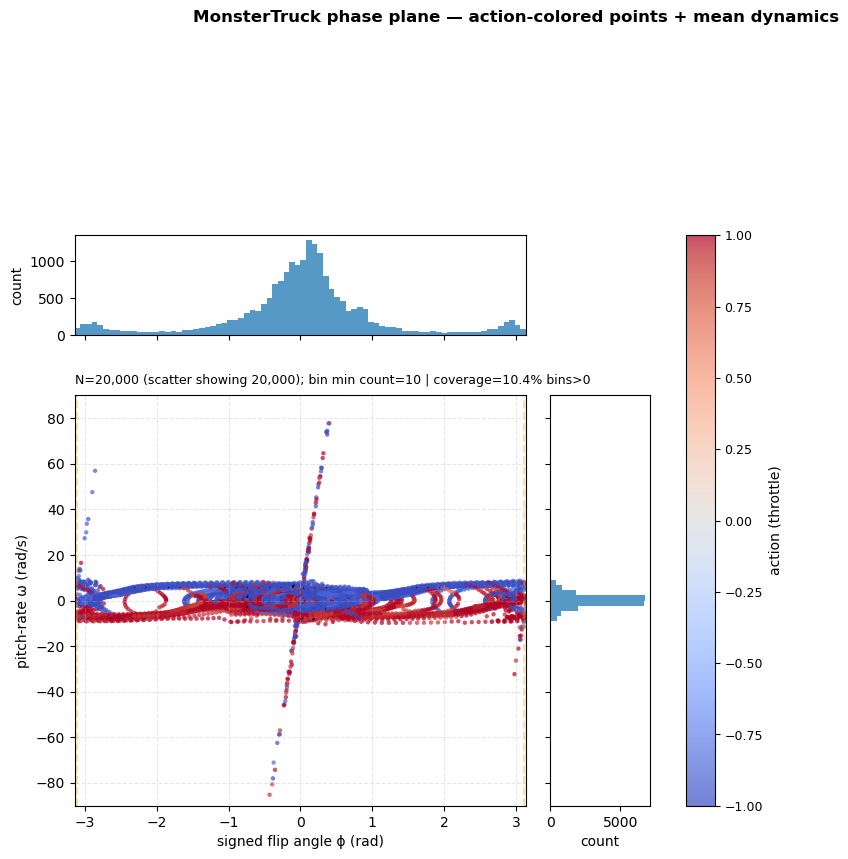

In [5]:
# =========================================================
# Cell 3 — Phase plane viz (radians) — robust to occ/bin shape
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# ---------- Tunables ----------
BINS_PHI_FALLBACK   = 41
BINS_OMEGA_FALLBACK = 41
ARROW_STRIDE = 2
MIN_BIN_CNT  = 10
MAX_POINTS   = 100_000
DENS_BINS    = (80, 80)
Q_LO, Q_HI   = 0.5, 99.5

# Layout
PAD_TOP, PAD_RIGHT = 0.60, 0.24
HEIGHT_TOP, WIDTH_RIGHT = 1.0, 1.0
FIG_LEFT, FIG_RIGHT, FIG_BOTTOM, FIG_TOP = 0.08, 0.92, 0.10, 0.92
CBAR_PAD = 0.05

TITLE = "MonsterTruck phase plane — action-colored points + mean dynamics"
SUCCESS_ENTER = globals().get("SUCCESS_ENTER_RAD", np.deg2rad(178.0))

# ---------- Decide which grid to use ----------
have_occ = ('occ_counts' in globals())
have_edges = ('phi_edges' in globals()) and ('omg_edges' in globals())

use_occ_bins = False
if have_occ:
    ny, nx = occ_counts.shape  # ny = omega bins, nx = phi bins
    if have_edges and (len(phi_edges) == nx + 1) and (len(omg_edges) == ny + 1):
        phi_edges_plot = np.asarray(phi_edges)
        omg_edges_plot = np.asarray(omg_edges)
        use_occ_bins = True
    else:
        # Rebuild compatible edges from data percentiles and occ grid shape
        phi_lo, phi_hi = np.percentile(phi_rad,     [Q_LO, Q_HI])
        omg_lo, omg_hi = np.percentile(omega_rad_s, [Q_LO, Q_HI])
        phi_edges_plot = np.linspace(phi_lo, phi_hi, nx + 1)
        omg_edges_plot = np.linspace(omg_lo, omg_hi, ny + 1)
        use_occ_bins = True
else:
    # No occupancy grid available → fallback uniform bins from data
    phi_lo, phi_hi = np.percentile(phi_rad,     [Q_LO, Q_HI])
    omg_lo, omg_hi = np.percentile(omega_rad_s, [Q_LO, Q_HI])
    phi_edges_plot = np.linspace(phi_lo, phi_hi, BINS_PHI_FALLBACK + 1)
    omg_edges_plot = np.linspace(omg_lo, omg_hi, BINS_OMEGA_FALLBACK + 1)

# Use edges to set consistent limits and centers
phi_lo, phi_hi = float(phi_edges_plot[0]),  float(phi_edges_plot[-1])
omg_lo, omg_hi = float(omg_edges_plot[0]),  float(omg_edges_plot[-1])
BINS_PHI   = len(phi_edges_plot) - 1
BINS_OMEGA = len(omg_edges_plot) - 1
phi_centers = 0.5 * (phi_edges_plot[:-1] + phi_edges_plot[1:])
omg_centers = 0.5 * (omg_edges_plot[:-1] + omg_edges_plot[1:])

# ---------- Figure ----------
fig = plt.figure(figsize=(11.6, 9.2))
fig.subplots_adjust(left=FIG_LEFT, right=FIG_RIGHT, bottom=FIG_BOTTOM, top=FIG_TOP)
fig.suptitle(TITLE, y=0.985, fontsize=12, fontweight="bold")

# Main axis
ax = fig.add_axes([0.12, 0.12, 0.62, 0.62])

# Background: occupancy if available, else 2D density
if use_occ_bins and have_occ:
    H_bg = occ_counts.astype(float)  # shape (ny=omega, nx=phi) — DO NOT transpose
    ax.pcolormesh(phi_edges_plot, omg_edges_plot, H_bg, shading="auto", cmap="Greys", alpha=0.18)
else:
    H, xedges, yedges = np.histogram2d(
        phi_rad, omega_rad_s, bins=DENS_BINS, range=[[phi_lo, phi_hi], [omg_lo, omg_hi]]
    )
    ax.pcolormesh(xedges, yedges, H.T, shading="auto", cmap="Greys", alpha=0.15)

# Scatter (downsample if huge)
N = phi_rad.shape[0]
idx = np.random.default_rng(0).choice(N, size=MAX_POINTS, replace=False) if N > MAX_POINTS else slice(None)
norm = TwoSlopeNorm(vcenter=0.0, vmin=float(act.min()), vmax=float(act.max()))
pts = ax.scatter(
    phi_rad[idx], omega_rad_s[idx],
    c=act[idx], s=10, cmap="coolwarm", norm=norm, edgecolors="none", alpha=0.7
)

# Quiver: mean (Δφ, Δω) per bin aligned with edges in use
sum_dphi = np.zeros((BINS_PHI, BINS_OMEGA), dtype=np.float64)
sum_domg = np.zeros_like(sum_dphi)
count    = np.zeros_like(sum_dphi)

phi_idx = np.clip(np.digitize(phi_rad,     phi_edges_plot) - 1, 0, BINS_PHI   - 1)
omg_idx = np.clip(np.digitize(omega_rad_s, omg_edges_plot) - 1, 0, BINS_OMEGA - 1)

for i in range(phi_idx.size):
    sum_dphi[phi_idx[i], omg_idx[i]] += dphi_rad[i]
    sum_domg[phi_idx[i], omg_idx[i]] += domega_rad_s[i]
    count[phi_idx[i], omg_idx[i]]    += 1

mask = count >= MIN_BIN_CNT
U = np.zeros_like(sum_dphi); V = np.zeros_like(sum_dphi)
U[mask] = sum_dphi[mask] / count[mask]
V[mask] = sum_domg[mask] / count[mask]

sel = (np.arange(BINS_PHI)   % ARROW_STRIDE == 0)[:, None] & \
      (np.arange(BINS_OMEGA) % ARROW_STRIDE == 0)[None, :] & mask

mag = np.hypot(U[sel], V[sel])
p95 = np.percentile(mag[mag > 0], 95) if np.any(mag > 0) else 1.0
desired_len = 0.12 * (phi_hi - phi_lo)
quiver_scale = (p95 / desired_len) if p95 > 0 else 1.0

Xg, Yg = np.meshgrid(phi_centers, omg_centers, indexing="ij")
ax.quiver(
    Xg[sel], Yg[sel], U[sel], V[sel],
    angles="xy", scale_units="xy", scale=quiver_scale,
    width=0.002, headwidth=3.5, headlength=4.5, headaxislength=4.0,
    color="k", alpha=0.85
)

# Success band shading
ax.axvspan(SUCCESS_ENTER,  np.pi, color="#ffd54f", alpha=0.12, linewidth=0)
ax.axvspan(-np.pi, -SUCCESS_ENTER, color="#ffd54f", alpha=0.12, linewidth=0)
ax.axvline(SUCCESS_ENTER,  color="#f9a825", alpha=0.35, linestyle="--", linewidth=1.5)
ax.axvline(-SUCCESS_ENTER, color="#f9a825", alpha=0.35, linestyle="--", linewidth=1.5)

# Labels, limits, colorbar
ax.set_xlim(phi_lo, phi_hi)
ax.set_ylim(omg_lo, omg_hi)
ax.set_xlabel("signed flip angle ϕ (rad)")
ax.set_ylabel("pitch-rate ω (rad/s)")
cb = plt.colorbar(pts, ax=ax, pad=CBAR_PAD)
cb.set_label("action (throttle)")
cb.ax.tick_params(labelsize=9)
ax.grid(True, which="both", alpha=0.3, linestyle="--", linewidth=0.8)

# Marginal histograms
divider = make_axes_locatable(ax)
ax_histx = divider.append_axes("top",   HEIGHT_TOP,  pad=PAD_TOP,   sharex=ax)
ax_histy = divider.append_axes("right", WIDTH_RIGHT, pad=PAD_RIGHT, sharey=ax)
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)
ax_histx.hist(phi_rad,     bins=80, range=(phi_lo, phi_hi), alpha=0.75)
ax_histy.hist(omega_rad_s, bins=80, range=(omg_lo, omg_hi),
              orientation="horizontal", alpha=0.75)
ax_histx.set_ylabel("count")
ax_histy.set_xlabel("count")

# Footer
Nshow = (phi_rad.shape[0] if isinstance(idx, slice) else int(np.size(idx)))
cov_txt = ""
if have_occ:
    nz = (occ_counts > 0)
    cov = 100.0 * np.count_nonzero(nz) / occ_counts.size
    cov_txt = f" | coverage={cov:.1f}% bins>0"
ax.text(0.0, 1.02,
        f"N={phi_rad.shape[0]:,} (scatter showing {Nshow:,}); bin min count={MIN_BIN_CNT}{cov_txt}",
        transform=ax.transAxes, fontsize=9, va="bottom")

plt.show()


# GP MODEL NEW

# CELL A

In [7]:
# ===== Cell A: Tensor prep (MonsterTruck, radians) =====
import numpy as np, torch
import gpytorch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# X = [ϕ, ω, u],  Y = [Δϕ, Δω]  (all radians or rad/s)
X_np = np.column_stack([phi_rad, omega_rad_s, act]).astype(np.float32)      # (N,3)
Y_np = np.column_stack([dphi_rad, domega_rad_s]).astype(np.float32)         # (N,2)

# Torch tensors (single creation, dtype set)
Xtr = torch.tensor(X_np, device=device, dtype=torch.float32)
Ytr = torch.tensor(Y_np, device=device, dtype=torch.float32)

# Per-dimension standardization (inputs & outputs)
eps = 1e-6
X_mu, X_std = Xtr.mean(0), Xtr.std(0).clamp_min(eps)
Y_mu, Y_std = Ytr.mean(0), Ytr.std(0).clamp_min(eps)

Xz = (Xtr - X_mu) / X_std            # (N,3)
Yz = (Ytr - Y_mu) / Y_std            # (N,2)

N = Xz.shape[0]
print(f"N = {N} | Xz: {Xz.shape} | Yz: {Yz.shape}")

# --- safety checks ---
assert X_np.shape == (N, 3) and Y_np.shape == (N, 2)
assert np.isfinite(X_np).all() and np.isfinite(Y_np).all(), "NaNs/infs in data"

# --- 1-step consistency check (same control interval), wrapped for φ ---
def wrapdiff(a, b):
    return ((a - b + np.pi) % (2*np.pi)) - np.pi

phi_next_meas   = np.array(phi_rad[1:], dtype=np.float32)
phi_next_from_d = np.array(phi_rad[:-1] + dphi_rad[:-1], dtype=np.float32)
phi_err = wrapdiff(phi_next_meas, phi_next_from_d)

omg_next_meas   = np.array(omega_rad_s[1:], dtype=np.float32)
omg_next_from_d = np.array(omega_rad_s[:-1] + domega_rad_s[:-1], dtype=np.float32)
omg_err = omg_next_meas - omg_next_from_d

print(f"Δφ consistency (median/95%): {np.median(np.abs(phi_err)):.3e} / {np.percentile(np.abs(phi_err),95):.3e} rad")
print(f"Δω consistency (median/95%): {np.median(np.abs(omg_err)):.3e} / {np.percentile(np.abs(omg_err),95):.3e} rad/s")


Using device: cuda
N = 20000 | Xz: torch.Size([20000, 3]) | Yz: torch.Size([20000, 2])
Δφ consistency (median/95%): 0.000e+00 / 2.384e-07 rad
Δω consistency (median/95%): 0.000e+00 / 2.384e-07 rad/s


# CELL B

In [6]:
# ===== Cell B: LMC-SVGP model (MonsterTruck, radians) =====
import math, torch, gpytorch
from gpytorch.variational import (
    VariationalStrategy, CholeskyVariationalDistribution, LMCVariationalStrategy
)

num_tasks   = 2      # outputs: [Δϕ, Δω]
num_latents = 2      # latent GPs in the LMC head (1–3 are typical)
M           = 256    # inducing points (64–512)

# ---- inducing points (in standardized Xz space) ----
with torch.no_grad():
    mins = Xz.min(0).values
    maxs = Xz.max(0).values
    side = int(round(M ** (1/3)))            # side per axis
    g0 = torch.linspace(mins[0], maxs[0], side + 2, device=device)
    g1 = torch.linspace(mins[1], maxs[1], side + 2, device=device)
    g2 = torch.linspace(mins[2], maxs[2], side + 2, device=device)
    G  = torch.stack(torch.meshgrid(g0, g1, g2, indexing="ij"), dim=-1).reshape(-1, 3)
    # Deterministic subsample to exactly M points without duplicates
    gen = torch.Generator(device=device)
    gen.manual_seed(0)
    idx = torch.randperm(G.shape[0], generator=gen, device=device)[:M]
    inducing_points = G[idx].contiguous()  # (M, 3)

class LMC_MTSVGP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, num_latents=2, num_tasks=2):
        # Batch over latents: (Q, M, D)
        inducing_points = inducing_points.unsqueeze(0).expand(num_latents, -1, -1)
        q_u = CholeskyVariationalDistribution(
            inducing_points.size(-2),
            batch_shape=torch.Size([num_latents])
        )
        base_vs = VariationalStrategy(
            self, inducing_points, q_u, learn_inducing_locations=True
        )
        lmc_vs = LMCVariationalStrategy(
            base_vs, num_tasks=num_tasks, num_latents=num_latents, latent_dim=-1
        )
        super().__init__(lmc_vs)

        self.mean_module = gpytorch.means.ConstantMean(
            batch_shape=torch.Size([num_latents])
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                batch_shape=torch.Size([num_latents]),
                ard_num_dims=3  # inputs are [ϕ, ω, u] in z-space
            ),
            batch_shape=torch.Size([num_latents])
        )

        # Optional: sane init for standardized inputs
        with torch.no_grad():
            self.covar_module.base_kernel.lengthscale.fill_(1.0)  # per-dim ~1
            self.covar_module.outputscale.fill_(1.0)
            self.mean_module.constant.fill_(0.0)

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

model = LMC_MTSVGP(inducing_points.to(device), num_latents=num_latents, num_tasks=num_tasks).to(device)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)

print(f"{sum(p.numel() for p in model.parameters())/1e6:.3f} M params (approx)")


NameError: name 'Xz' is not defined

# CELL C

In [9]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [10]:
# ===== Cell C: Train SVGP with ELBO (MonsterTruck, radians) =====
import torch, gpytorch, tqdm

# Choose optimizer style (keep False to match your current setup)
USE_NGD = False   # set True later to use NGD+Adam for stabler SVGP training

model.train(); likelihood.train()

if USE_NGD:
    # Natural Gradient Descent for variational params + Adam for hypers/likelihood
    from gpytorch.optim import NGD
    opt_ngd  = NGD(model.variational_parameters(), num_data=Yz.size(0), lr=0.10)
    opt_adam = torch.optim.Adam(
        list(model.hyperparameters()) + list(likelihood.parameters()),
        lr=0.02
    )
else:
    # Your original single-optimizer setup
    opt = torch.optim.Adam([
        {'params': model.parameters(),      'lr': 0.08},
        {'params': likelihood.parameters(), 'lr': 0.05},
    ])

# Variational ELBO; using full-batch since Xz/Yz already on device
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Yz.size(0))

E =800  # epochs
pbar = tqdm.tqdm(range(E))
for e in pbar:
    if USE_NGD:
        opt_ngd.zero_grad()
        opt_adam.zero_grad()
    else:
        opt.zero_grad()

    out  = model(Xz)
    loss = -mll(out, Yz)  # negative ELBO
    loss.backward()

    if USE_NGD:
        opt_ngd.step()   # update q(u)
        opt_adam.step()  # update kernel hypers + likelihood
    else:
        opt.step()

    if (e + 1) % 100 == 0:
        # Report average lengthscale across latents (handles ARD or not)
        try:
            ls = model.covar_module.base_kernel.lengthscale.detach().view(-1).mean().item()
        except Exception:
            ls = float('nan')
        # Multitask noise (mean across tasks), fallback if single noise
        try:
            noise = likelihood.task_noises.detach().mean().item()
        except Exception:
            noise = float(getattr(getattr(likelihood, "noise_covar", None), "noise", torch.tensor(float('nan'))).mean().item())
        pbar.set_description(f"NELBO {loss.item():.9f} | ls~{ls:.9f} | noise~{noise:.9f}")

model.eval(); likelihood.eval()


NELBO 2.350419998 | ls~4.144974232 | noise~0.303060919: 100%|██████████| 800/800 [00:30<00:00, 25.89it/s]


MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [11]:
# # ===== Cell C+ — freeze references to the trained GP pieces =====
# gp_model_trained = model          # keep a stable handle (avoids name collisions)
# gp_lik_trained   = likelihood


In [12]:
# #Build visualization adapters (robust + snapshot) =====
# import numpy as np, torch, gpytorch
# from gpytorch.likelihoods.likelihood import Likelihood
#
# # 1) Prefer frozen refs from Cell C+
# mtgp_model = None
# mtgp_lik   = None
# if 'gp_model_trained' in globals() and isinstance(gp_model_trained, gpytorch.models.ApproximateGP):
#     mtgp_model = gp_model_trained
# if 'gp_lik_trained' in globals() and isinstance(gp_lik_trained, Likelihood):
#     mtgp_lik = gp_lik_trained
#
# # 2) If still missing, fall back to common names
# if mtgp_model is None and 'model' in globals() and isinstance(globals()['model'], gpytorch.models.ApproximateGP):
#     mtgp_model = globals()['model']
# if mtgp_lik is None and 'likelihood' in globals() and isinstance(globals()['likelihood'], Likelihood):
#     mtgp_lik = globals()['likelihood']
#
# # 3) If still missing, take a SNAPSHOT of globals and scan safely
# if mtgp_model is None or mtgp_lik is None:
#     for k, v in list(globals().items()):      # <— snapshot avoids "dict changed size"
#         if mtgp_model is None and isinstance(v, gpytorch.models.ApproximateGP):
#             mtgp_model = v
#         if mtgp_lik   is None and isinstance(v, Likelihood):
#             mtgp_lik = v
#         if (mtgp_model is not None) and (mtgp_lik is not None):
#             break
#
# assert mtgp_model is not None, "Could not locate a gpytorch ApproximateGP (did Cell C run?)."
# assert mtgp_lik   is not None, "Could not locate a gpytorch Likelihood (did Cell C run?)."
#
# # Device from your standardized inputs (Cell A)
# _device = Xz.device
#
# # Raw training arrays (physical units) from Cell A
# X_raw = np.asarray(X_np, dtype=np.float32)  # [ϕ, ω, u]
# Y_raw = np.asarray(Y_np, dtype=np.float32)  # [Δϕ, Δω]
#
# # Standardization stats → numpy
# X_mu_np = X_mu.detach().cpu().numpy()
# X_std_np = X_std.detach().cpu().numpy()
# Y_mu_np = Y_mu.detach().cpu().numpy()
# Y_std_np = Y_std.detach().cpu().numpy()
#
# class GPHeadAdapter:
#     """Expose dataset() and predict(X_raw) for one multitask head (0:Δϕ, 1:Δω)."""
#     def __init__(self, model, likelihood, task_idx, X_raw, Y_raw, X_mu, X_std, Y_mu, Y_std):
#         self.model = model
#         self.lik   = likelihood
#         self.ti    = int(task_idx)
#         self.X_raw = np.asarray(X_raw)
#         self.Y_raw = np.asarray(Y_raw)[:, self.ti]
#         self.X_mu  = np.asarray(X_mu)
#         self.X_std = np.asarray(X_std)
#         self.Y_mu  = np.asarray(Y_mu)
#         self.Y_std = np.asarray(Y_std)
#
#     def dataset(self):
#         return self.X_raw, self.Y_raw
#
#     @torch.no_grad()
#     def predict(self, X_query_raw):
#         X_query_raw = np.asarray(X_query_raw, dtype=np.float32)
#         Xz = (X_query_raw - self.X_mu) / self.X_std
#         Xt = torch.tensor(Xz, dtype=torch.float32, device=_device)
#
#         self.model.eval(); self.lik.eval()
#         with gpytorch.settings.fast_pred_var():
#             post = self.lik(self.model(Xt))
#
#         mean = post.mean
#         var  = post.variance
#         if mean.ndim == 2:     # (N, T)
#             m = mean[:, self.ti]
#             v = var[:,  self.ti]
#         else:                  # (N,)
#             m = mean
#             v = var
#
#         m = m.detach().cpu().numpy()
#         v = v.detach().cpu().numpy()
#
#         # Unstandardize outputs
#         m_phys = m * self.Y_std[self.ti] + self.Y_mu[self.ti]
#         v_phys = v * (self.Y_std[self.ti] ** 2)
#         return m_phys, v_phys
#
# # Build heads: gps[0]=Δϕ, gps[1]=Δω
# gps = [
#     GPHeadAdapter(mtgp_model, mtgp_lik, 0, X_raw, Y_raw, X_mu_np, X_std_np, Y_mu_np, Y_std_np),
#     GPHeadAdapter(mtgp_model, mtgp_lik, 1, X_raw, Y_raw, X_mu_np, X_std_np, Y_mu_np, Y_std_np),
# ]
# print("gps ready ✅  (gps[0]=Δϕ, gps[1]=Δω) | device:", _device)


In [13]:
# # — Δω(ϕ, ω | a) surfaces (with training overlay) =====
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
#
# gp = gps[1]  # Δω head
# A_VALUES   = [-1.0, 0.0, 1.0]
# ACTION_TOL = 0.5
#
# Xtr, Ytr = gp.dataset()
# phi_tr, omg_tr, act_tr = Xtr[:, 0], Xtr[:, 1], Xtr[:, 2]
#
# # Grid bounds (fallbacks if degenerate)
# phi_min, phi_max = (phi_tr.min(), phi_tr.max()) if np.ptp(phi_tr) > 1e-6 else (-np.pi, np.pi)
# omg_min, omg_max = (omg_tr.min(), omg_tr.max()) if np.ptp(omg_tr) > 1e-6 else (-15.0, 15.0)
#
# phi_grid = np.linspace(phi_min, phi_max, 60, dtype=np.float32)
# omg_grid = np.linspace(omg_min, omg_max, 60, dtype=np.float32)
# PHI, OMG = np.meshgrid(phi_grid, omg_grid)
#
# for a_fixed in A_VALUES:
#     X_grid = np.column_stack([
#         PHI.ravel(),
#         OMG.ravel(),
#         np.full(PHI.size, a_fixed, dtype=np.float32)
#     ])
#     Mean, Var = gp.predict(X_grid)
#     Mean = Mean.reshape(PHI.shape)
#
#     fig = plt.figure(figsize=(9, 6))
#     ax = fig.add_subplot(111, projection='3d')
#     surf = ax.plot_surface(PHI, OMG, Mean, cmap='coolwarm',
#                            linewidth=0, antialiased=True, alpha=0.9)
#
#     mask = np.abs(act_tr - a_fixed) < ACTION_TOL
#     if np.any(mask):
#         ax.scatter(phi_tr[mask], omg_tr[mask], Ytr[mask],
#                    color='k', s=15, alpha=0.7, label=f'train (a≈{a_fixed:+.1f})')
#
#     ax.set_xlabel('Pitch ϕ (rad)')
#     ax.set_ylabel('Pitch rate ω (rad/s)')
#     ax.set_zlabel('Δω (rad/s per step)')
#     ax.set_title(f"GP mean Δω over (ϕ, ω) @ a={a_fixed:+.1f}")
#     fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean Δω')
#     if np.any(mask): ax.legend()
#     plt.tight_layout()
#     plt.show()


In [14]:
# #  Δω surface with predictive Std color (single action) =====
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import colors as mcolors
#
# gp = gps[1]          # Δω head
# a_fixed = -1.0       # choose a throttle to inspect
#
# Xtr, Ytr = gp.dataset()
# phi_tr, omg_tr, act_tr = Xtr[:, 0], Xtr[:, 1], Xtr[:, 2]
#
# phi_grid = np.linspace(min(phi_tr.min(), -np.pi), max(phi_tr.max(),  np.pi), 80, dtype=np.float32)
# omg_grid = np.linspace(min(omg_tr.min(), -15.0),  max(omg_tr.max(),  15.0), 80, dtype=np.float32)
# PHI, OMG = np.meshgrid(phi_grid, omg_grid)
#
# X_grid = np.column_stack([
#     PHI.ravel(),
#     OMG.ravel(),
#     np.full(PHI.size, a_fixed, dtype=np.float32)
# ])
#
# Mean, Var = gp.predict(X_grid)
# Mean = Mean.reshape(PHI.shape)
# Std  = np.sqrt(Var.reshape(PHI.shape))
#
# norm = mcolors.Normalize(vmin=Std.min(), vmax=Std.max())
# facecols = plt.cm.viridis(norm(Std))
#
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# surf = ax.plot_surface(PHI, OMG, Mean, facecolors=facecols,
#                        linewidth=0, antialiased=False, shade=False)
#
# m = plt.cm.ScalarMappable(cmap='viridis', norm=norm); m.set_array(Std)
# cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10); cbar.set_label('Predictive Std (Δω)')
#
# mask = np.abs(act_tr - a_fixed) < 0.5
# if np.any(mask):
#     ax.scatter(phi_tr[mask], omg_tr[mask], Ytr[mask],
#                color='k', s=15, alpha=0.6, label=f'train (a≈{a_fixed:+.1f})')
#
# ax.set_xlabel('Pitch ϕ (rad)')
# ax.set_ylabel('Pitch rate ω (rad/s)')
# ax.set_zlabel('Δω (rad/s per step)')
# ax.set_title(f"Δω surface (height) + uncertainty (color), a={a_fixed:+.1f}")
# ax.view_init(elev=30, azim=230)
# if np.any(mask): ax.legend()
# plt.tight_layout()
# plt.show()


In [15]:
# # Δϕ vs ϕ (fix ω, a) with ±2σ + data overlay =====
# import numpy as np
# import matplotlib.pyplot as plt
#
# gp = gps[0]       # Δϕ head
# omega_fixed = 0.0
# a_fixed     = -1.0
#
# phi_grid = np.linspace(-np.pi, np.pi, 300, dtype=np.float32)
# X_query = np.column_stack([
#     phi_grid,
#     np.full_like(phi_grid, omega_fixed, dtype=np.float32),
#     np.full_like(phi_grid, a_fixed,      dtype=np.float32)
# ])
#
# Mean, Var = gp.predict(X_query)
# Std = np.sqrt(Var)
#
# plt.figure(figsize=(8, 5))
# plt.plot(phi_grid, Mean, lw=2, label='GP mean Δϕ')
# plt.fill_between(phi_grid, Mean - 2*Std, Mean + 2*Std, alpha=0.2, label='±2σ')
#
# Xtr, Ytr = gp.dataset()
# mask = (np.abs(Xtr[:, 1] - omega_fixed) < 0.05) & (np.abs(Xtr[:, 2] - a_fixed) < 0.5)
# if np.any(mask):
#     plt.scatter(Xtr[mask, 0], Ytr[mask], s=22, alpha=0.7, color='k',
#                 label='train (ω≈0, a≈fixed)')
#
# plt.xlabel("Pitch ϕ (rad)")
# plt.ylabel("Δϕ (rad per step)")
# plt.title(f"Δϕ vs ϕ  |  ω={omega_fixed:+.2f} rad/s,  a={a_fixed:+.1f}")
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.tight_layout()
# plt.show()


# CELL D

In [16]:
# ===== Cell D: GP prediction & one-step model (MonsterTruck, radians) =====
import numpy as np
import torch
import gpytorch

@torch.no_grad()
def gp_predict_delta(pos_batch, vel_batch, act_batch, sample=False, chunk=None, include_noise=True):
    """
    Inputs can be numpy or torch. Returns:
      m_dpos, s_dpos, m_dvel, s_dvel   (all in real units)
    If sample=True, also returns: dpos_samp, dvel_samp  (one draw)
    include_noise=True => var includes observation noise (likelihood); False => latent f var only.
    """
    if not torch.is_tensor(pos_batch):
        Xb = torch.tensor(
            np.column_stack([pos_batch, vel_batch, act_batch]),
            dtype=torch.float32, device=device
        )
    else:
        Xb = torch.stack([pos_batch, vel_batch, act_batch], dim=-1).to(device).float()

    # standardize inputs
    Xb_z = (Xb - X_mu) / X_std

    model.eval(); likelihood.eval()

    def _predict_block(Xz_block):
        if include_noise:
            dist = likelihood(model(Xz_block))
        else:
            dist = model(Xz_block)  # latent function (no observation noise)
        mean = dist.mean
        var  = dist.variance
        # de-standardize to original units
        mean = mean * Y_std + Y_mu
        std  = var.clamp_min(1e-12).sqrt() * Y_std
        if sample:
            samp = (dist.rsample() * Y_std + Y_mu)
            return mean, std, samp
        else:
            return mean, std, None

    if chunk is None:
        with gpytorch.settings.fast_pred_var():
            mean, std, samp = _predict_block(Xb_z)
        m_dp = mean[..., 0].detach().cpu().numpy()
        m_dv = mean[..., 1].detach().cpu().numpy()
        s_dp = std[..., 0].detach().cpu().numpy()
        s_dv = std[..., 1].detach().cpu().numpy()
        if not sample:
            return m_dp, s_dp, m_dv, s_dv
        dpos_samp = samp[..., 0].detach().cpu().numpy()
        dvel_samp = samp[..., 1].detach().cpu().numpy()
        return m_dp, s_dp, m_dv, s_dv, dpos_samp, dvel_samp

    # chunked path
    outs = []
    for i in range(0, Xb_z.shape[0], chunk):
        xb = Xb_z[i:i+chunk]
        with gpytorch.settings.fast_pred_var():
            mean, std, samp = _predict_block(xb)
        outs.append((mean, std, samp))
    mean = torch.cat([o[0] for o in outs], 0)
    std  = torch.cat([o[1] for o in outs], 0)

    m_dp = mean[..., 0].detach().cpu().numpy()
    m_dv = mean[..., 1].detach().cpu().numpy()
    s_dp = std[..., 0].detach().cpu().numpy()
    s_dv = std[..., 1].detach().cpu().numpy()
    if not sample:
        return m_dp, s_dp, m_dv, s_dv
    samp = torch.cat([o[2] for o in outs], 0)
    dpos_samp = samp[..., 0].detach().cpu().numpy()
    dvel_samp = samp[..., 1].detach().cpu().numpy()
    return m_dp, s_dp, m_dv, s_dv, dpos_samp, dvel_samp


def wrap_angle_rad(x):
    # map to (-pi, pi]
    return ((x + np.pi) % (2.0 * np.pi)) - np.pi


def gp_step(state_batch, action_batch, dt=1.0, stochastic=False, wrap_angle=False, **pred_kwargs):
    """
    Vectorized one-step model for MPPI / rollouts.

    Inputs:
      state_batch : (B, 2) array-like with [ϕ, ω]
      action_batch: (B,) or (B,1)
      dt          : macro-step multiplier (keep 1.0; targets are already per macro-step)
      stochastic  : if True, draw one sample; else use mean
      wrap_angle  : if True, wraps ϕ_next into (-π, π]
      **pred_kwargs: forwarded to gp_predict_delta (e.g., chunk=8192, include_noise=True/False)

    Returns:
      next_state (B, 2) with [ϕ_next, ω_next]
    """
    sb = torch.as_tensor(state_batch, device=device, dtype=torch.float32)
    ab = torch.as_tensor(action_batch, device=device, dtype=torch.float32).view(-1)
    phi_b, omg_b = sb[:, 0], sb[:, 1]

    if stochastic:
        m_dp, _, m_dv, _, dphi_samp, domega_samp = gp_predict_delta(phi_b, omg_b, ab, sample=True, **pred_kwargs)
        dphi, domega = dphi_samp, domega_samp
    else:
        m_dp, _, m_dv, _ = gp_predict_delta(phi_b, omg_b, ab, sample=False, **pred_kwargs)
        dphi, domega = m_dp, m_dv

    phi_next = phi_b.detach().cpu().numpy() + dphi * dt
    omg_next = omg_b.detach().cpu().numpy() + domega * dt

    if wrap_angle:
        phi_next = wrap_angle_rad(phi_next)

    return np.stack([phi_next, omg_next], axis=-1)


# CELL E

In [17]:
# GP dynamics adapter for MPPI (MonsterTruck, radians)
# - X = [ϕ, ω, u], Y = [Δϕ, Δω] per macro-step (FRAME_SKIP * dt_mj)
# - Uses trained multitask SVGP `model`, `likelihood`, and {X_mu, X_std, Y_mu, Y_std}

import numpy as np
import torch, gpytorch

class SVGPDynamics:
    def __init__(self, model, likelihood, X_mu, X_std, Y_mu, Y_std, device=None):
        self.model = model.eval()
        self.lik   = likelihood.eval()
        self.device = device or next(model.parameters()).device

        # Cache standardization stats on correct device (ensure 1-D)
        self.X_mu  = X_mu.to(self.device).view(-1)                  # (3,)
        self.X_std = X_std.clamp_min(1e-6).to(self.device).view(-1) # (3,)
        self.Y_mu  = Y_mu.to(self.device).view(-1)                  # (2,)
        self.Y_std = Y_std.clamp_min(1e-6).to(self.device).view(-1) # (2,)

        # Basic sanity checks
        assert self.X_mu.numel()  == 3 and self.X_std.numel() == 3, "X_mu/X_std must be length-3"
        assert self.Y_mu.numel()  == 2 and self.Y_std.numel() == 2, "Y_mu/Y_std must be length-2"

    @torch.no_grad()
    def _predict_delta(self, Xq):  # Xq: (B,3) tensor on device, columns [ϕ, ω, u]
        # standardize inputs
        Xqz = (Xq - self.X_mu) / self.X_std

        with gpytorch.settings.fast_pred_var():
            post = self.lik(self.model(Xqz))  # MultitaskMultivariateNormal

        # de-standardize outputs
        mean = post.mean * self.Y_std + self.Y_mu                # (B,2)
        var  = post.variance.clamp_min(1e-10) * (self.Y_std**2)  # (B,2)
        return mean, var

    @torch.no_grad()
    def step_batch(self, states, actions, stochastic=False, dt=1.0, wrap_angle=False):
        """
        states:  (B,2) [ϕ, ω] in radians / rad·s⁻¹   (np or torch)
        actions: (B,) or (B,1) throttle in [-1,1]     (np or torch)
        returns: next_states (B,2) numpy, same units; dt is macro-step scale (keep 1.0).
        """
        # to torch (float32) on the correct device
        if not torch.is_tensor(states):
            S = torch.as_tensor(states,  dtype=torch.float32, device=self.device)
        else:
            S = states.to(self.device, dtype=torch.float32)
        if not torch.is_tensor(actions):
            A = torch.as_tensor(actions, dtype=torch.float32, device=self.device).view(-1, 1)
        else:
            A = actions.to(self.device, dtype=torch.float32).view(-1, 1)

        # shape checks
        assert S.ndim == 2 and S.shape[1] == 2, f"states must be (B,2), got {tuple(S.shape)}"
        assert A.ndim == 2 and A.shape[1] == 1, f"actions must be (B,1) or (B,), got {tuple(A.shape)}"
        assert S.shape[0] == A.shape[0], "states and actions batch size must match"

        # query (B,3) = [ϕ, ω, u]
        Xq = torch.cat([S, A], dim=1)
        mean, var = self._predict_delta(Xq)  # (B,2), (B,2)

        # choose mean or one Gaussian sample
        if stochastic:
            std = var.sqrt()
            d = mean + torch.randn_like(std) * std
        else:
            d = mean

        S_next = S + d * float(dt)  # per macro-step

        if wrap_angle:
            # wrap ϕ into (-π, π]
            phi = S_next[:, 0]
            # use torch-friendly wrap to avoid dtype/device hops
            phi = torch.remainder(phi + np.pi, 2.0 * np.pi) - np.pi
            S_next = torch.stack([phi, S_next[:, 1]], dim=-1)

        return S_next.detach().cpu().numpy()


In [18]:
# === Cell F — MonsterTruck GP dynamics adapter (radians) ===
# State = [ϕ (rad), ω (rad/s)], Action = throttle u ∈ [-1, 1]
# Deltas are per macro-step (FRAME_SKIP), consistent with your collectors.

import torch

# Use model's device when available
gp_device = next(model.parameters()).device if any(p.requires_grad for p in model.parameters()) else torch.device("cpu")

# Quick sanity checks on stats (guards against shape drift)
assert X_mu.shape[-1]  == 3 and X_std.shape[-1] == 3, "X stats must be length-3 (ϕ, ω, u)"
assert Y_mu.shape[-1]  == 2 and Y_std.shape[-1] == 2, "Y stats must be length-2 (Δϕ, Δω)"

dyn = SVGPDynamics(
    model,
    likelihood,
    X_mu, X_std,   # from Cell A (computed on [ϕ, ω, u])
    Y_mu, Y_std,   # from Cell A (computed on [Δϕ, Δω])
    device=gp_device
)

print("SVGPDynamics ready on:", dyn.device)

# # Optional smoke test (leave commented to keep side-effect free):
# S0 = torch.zeros(4, 2, device=gp_device)   # [ϕ, ω]
# A0 = torch.zeros(4, 1, device=gp_device)   # u
# _ = dyn.step_batch(S0, A0, stochastic=False)


SVGPDynamics ready on: cuda:0


# COST FUNCTION

In [19]:
# ===== Cell G (REPLACED): Two costs for MPPI — TASK (target) and EXPLORE (variance-seeking) =====
import numpy as np

# ----------------------------- TASK / target-focused cost -----------------------------
def build_monstertruck_cost_task(
    R=None,
    goal_sign=+1,                       # kept for API compatibility (unused)
    success_enter_rad=None,
    success_release_rad=None,           # ignored here
    max_upright_rate_rad=None,
    hold_needed=None,
):
    """
    Momentum-encouraged shaping toward upright (±π).
    Returns:
      step_cost(phi, omega, u, u_prev) -> (K,) cost
      terminal_bonus(phi_seq, omega_seq) -> scalar or (B,) negative cost when HOLD met
    """
    # Defaults, then override safely with user R
    R_defaults = {
        "position": 1.5,               # tanh^2 on directional distance to +π
        "tanh_gain": 1.5,
        "momentum": 0.75,              # reward |ω| when far from either upright
        "mom_gain": 1.0,
        "mom_power": 1.0,
        "energy": 0.05,                # u^2
        "time": 1.0,                   # per-step
        "jerk": 0.3,                   # |Δu|
        "steady_bonus": 0.0,           # optional holding bonus (off)
        "steady_phi_tol": np.deg2rad(2.0),
        "steady_omega_tol": np.deg2rad(3.0),
        "success": 2000.0,
    }
    if R:
        R_defaults.update(R)
    R = R_defaults

    SUCCESS_ENTER   = success_enter_rad    if success_enter_rad    is not None else np.deg2rad(178.0)
    MAX_UPRIGHT_OMG = max_upright_rate_rad if max_upright_rate_rad is not None else np.deg2rad(60.0)
    HOLD            = hold_needed          if hold_needed          is not None else 4

    def _wrap_to_pi(x): return (x + np.pi) % (2.0 * np.pi) - np.pi
    def _dist_near_upright(phi):
        d1 = np.abs(_wrap_to_pi(phi - np.pi))
        d2 = np.abs(_wrap_to_pi(phi + np.pi))
        return np.minimum(d1, d2)

    def step_cost(phi, omega, u, u_prev):
        phi    = np.asarray(phi,    dtype=float)
        omega  = np.asarray(omega,  dtype=float)
        u      = np.asarray(u,      dtype=float)
        u_prev = np.asarray(u_prev, dtype=float)

        # Position shaping toward +π (directional)
        d_fwd = (np.pi - phi) / np.pi
        d_clip2 = np.clip(d_fwd, 0.0, 2.0)
        pos_penalty = R["position"] * (np.tanh(R["tanh_gain"] * (2.0 * d_clip2)) ** 2)

        # Momentum encouragement (negative cost)
        d_near = _dist_near_upright(phi) / np.pi
        mom_gate = d_near ** R["mom_power"]
        mom_reward = R["momentum"] * np.tanh(R["mom_gain"] * np.abs(omega)) * mom_gate
        mom_term = -mom_reward

        # Energy / time / jerk
        energy_pen = R["energy"] * (u ** 2)
        time_pen   = R["time"]
        jerk_pen   = R["jerk"] * np.abs(u - u_prev)

        # Optional steady hold bonus
        steady = 0.0
        if R["steady_bonus"] > 0.0:
            close_angle = (np.abs(_wrap_to_pi(phi - np.pi)) <= R["steady_phi_tol"])
            slow_rate   = (np.abs(omega) <= R["steady_omega_tol"])
            steady = -R["steady_bonus"] * (close_angle & slow_rate).astype(float)

        return pos_penalty + mom_term + energy_pen + time_pen + jerk_pen + steady

    def terminal_bonus(phi_seq, omega_seq):
        phi_seq   = np.asarray(phi_seq,   dtype=float)
        omega_seq = np.asarray(omega_seq, dtype=float)

        def _ok(phi, omg): return (np.abs(phi) >= SUCCESS_ENTER) & (np.abs(omg) <= MAX_UPRIGHT_OMG)

        if phi_seq.ndim == 1:
            run = 0
            for t in range(phi_seq.shape[0]):
                if _ok(phi_seq[t], omega_seq[t]):
                    run += 1
                    if run >= HOLD: return -R["success"]
                else:
                    run = 0
            return 0.0
        elif phi_seq.ndim == 2:
            T, B = phi_seq.shape
            bonus = np.zeros((B,), dtype=float)
            run   = np.zeros((B,), dtype=int)
            hit   = np.zeros((B,), dtype=bool)
            for t in range(T):
                ok = _ok(phi_seq[t], omega_seq[t])
                run = np.where(ok, run + 1, 0)
                newly = (run >= HOLD) & (~hit)
                bonus[newly] = -R["success"]
                hit |= newly
            return bonus
        else:
            raise ValueError("terminal_bonus expects shapes (T,) or (T,B)")

    return step_cost, terminal_bonus


# ----------------------------- EXPLORE / variance-seeking cost -----------------------------
def build_monstertruck_cost_explore(
    beta_var=1.0,                 # >0 to seek uncertainty (we subtract it as cost)
    uncert_weights=(1.0, 1.0),    # weights for [var_dphi, var_domega]
    R_explore=None,               # small regularizers: energy/time/jerk
):
    """
    Exploration step cost that *seeks* epistemic variance from the GP:
      cost = energy*u^2 + time + jerk*|Δu|  - beta_var * (w_dp*Var[Δϕ] + w_dv*Var[Δω])
    No terminal bonus (purely per-step).
    Returns:
      step_cost_explore(phi, omega, u, u_prev, *, var_dp, var_dv, use_std=False) -> (K,) cost
      terminal_zero(...) -> 0
    """
    # Defaults then safe override
    R = {"energy": 0.01, "time": 0.1, "jerk": 0.1}
    if R_explore:
        R.update(R_explore)

    BETA  = float(beta_var)
    W_DP, W_DV = float(uncert_weights[0]), float(uncert_weights[1])

    def step_cost_explore(phi, omega, u, u_prev, *, var_dp=None, var_dv=None, use_std=False):
        if var_dp is None or var_dv is None:
            raise ValueError("Exploration cost needs var_dp and var_dv (per-sample).")
        phi    = np.asarray(phi,    dtype=float)
        omega  = np.asarray(omega,  dtype=float)
        u      = np.asarray(u,      dtype=float)
        u_prev = np.asarray(u_prev, dtype=float)
        vdp    = np.asarray(var_dp, dtype=float)
        vdv    = np.asarray(var_dv, dtype=float)
        if use_std:
            vdp = vdp**2; vdv = vdv**2

        energy_pen = R["energy"] * (u ** 2)
        time_pen   = R["time"]
        jerk_pen   = R["jerk"] * np.abs(u - u_prev)
        var_reward = BETA * (W_DP * vdp + W_DV * vdv)   # subtract to make high var attractive

        return energy_pen + time_pen + jerk_pen - var_reward

    def terminal_zero(*args, **kwargs):
        # No terminal shaping during exploration
        if isinstance(args[0], np.ndarray) and args[0].ndim == 2:
            B = args[0].shape[1]
            return np.zeros((B,), dtype=float)
        return 0.0

    return step_cost_explore, terminal_zero


# ----------------------------- MPPI-friendly wrappers -----------------------------
def make_state_cost_callbacks_task(
    R=None,
    goal_sign=+1,
    success_enter_rad=None,
    success_release_rad=None,
    max_upright_rate_rad=None,
    hold_needed=None,
):
    step_cost, terminal_bonus_seq = build_monstertruck_cost_task(
        R=R,
        goal_sign=goal_sign,
        success_enter_rad=success_enter_rad,
        success_release_rad=success_release_rad,
        max_upright_rate_rad=max_upright_rate_rad,
        hold_needed=hold_needed,
    )
    SUCCESS_ENTER   = success_enter_rad    if success_enter_rad    is not None else np.deg2rad(178.0)
    MAX_UPRIGHT_OMG = max_upright_rate_rad if max_upright_rate_rad is not None else np.deg2rad(60.0)

    def step_cost_cb(states, actions, u_prev):
        S = np.asarray(states,  dtype=float)
        U = np.asarray(actions, dtype=float).reshape(-1)
        Uprev = np.zeros_like(U) if u_prev is None else np.asarray(u_prev, dtype=float).reshape(-1)
        return step_cost(S[:, 0], S[:, 1], U, Uprev)

    def terminal_cost_final_cb(phi_final, omega_final):
        phi_final   = np.asarray(phi_final,   dtype=float).reshape(-1)
        omega_final = np.asarray(omega_final, dtype=float).reshape(-1)
        ok = (np.abs(phi_final) >= SUCCESS_ENTER) & (np.abs(omega_final) <= MAX_UPRIGHT_OMG)
        # Use user-provided R if available; otherwise default 2000
        success_w = (R["success"] if isinstance(R, dict) and "success" in R else 2000.0)
        bonus = np.zeros_like(phi_final, dtype=float)
        bonus[ok] = -success_w
        return bonus

    return step_cost_cb, terminal_cost_final_cb


def make_state_cost_callbacks_explore(
    beta_var=1.0,
    uncert_provider=None,        # callable(states, actions) -> (var_dp, var_dv) or (std_dp, std_dv)
    uncert_as_std=True,          # True if provider returns std; we square inside
    uncert_weights=(1.0, 1.0),
    R_explore=None,
):
    step_cost_explore, terminal_zero = build_monstertruck_cost_explore(
        beta_var=beta_var, uncert_weights=uncert_weights, R_explore=R_explore
    )

    def step_cost_cb(states, actions, u_prev, *, var_dp=None, var_dv=None):
        S = np.asarray(states,  dtype=float)
        U = np.asarray(actions, dtype=float).reshape(-1)
        Uprev = np.zeros_like(U) if u_prev is None else np.asarray(u_prev, dtype=float).reshape(-1)

        vdp, vdv = var_dp, var_dv
        if (vdp is None or vdv is None):
            if uncert_provider is None:
                raise ValueError("Exploration cost: provide (var_dp,var_dv) or set uncert_provider.")
            vdp, vdv = uncert_provider(S, U)  # expected in real units; std if uncert_as_std=True
        return step_cost_explore(S[:, 0], S[:, 1], U, Uprev,
                                 var_dp=vdp, var_dv=vdv, use_std=uncert_as_std)

    def terminal_cost_final_cb(phi_final, omega_final):
        return terminal_zero(phi_final, omega_final)

    return step_cost_cb, terminal_cost_final_cb


In [20]:
# === GP_MPPI (MonsterTruck, radians) — task/explore modes, GP-variance aware (NO external make_state_cost_callbacks) ===
# - Robust to different cost signatures and gp_predict_delta signatures
# - Always evaluates running cost on CURRENT state (S_curr)
# - Explore mode optionally injects GP uncertainty into the cost

import numpy as np

class GP_MPPI:
    def __init__(self,
                 horizon=80, n_samples=6000, lambda_=1.0,
                 u_sigma=0.55, action_low=-1.0, action_high=1.0,
                 sample_gp=False, seed=0, warm_start=True,
                 smooth_weight=0.0,
                 dynamics_adapter=None,
                 step_cost_fn=None, terminal_cost_fn=None,
                 cost_weights=None,                 # e.g., {"success": 2000.0}
                 # --- exploration plumbing ---
                 mode="task",                      # "task" or "explore"
                 uncert_provider=None,             # callable(states(K,2), actions(K,)) -> (std_or_var_dp, std_or_var_dv)
                 uncert_as_std=True,               # True if provider returns std; squared inside cost
                 var_chunk=8192,                   # used only by default provider (if any)
                 include_noise=False               # False => epistemic variance only
                 ):
        self.T   = int(horizon)
        self.K   = int(n_samples)
        self.lmb = float(lambda_)
        self.u_sigma_base = float(u_sigma)
        self.a_low, self.a_high = float(action_low), float(action_high)
        self.sample_gp = bool(sample_gp)
        self.rng = np.random.default_rng(seed)
        self.smooth_w = float(smooth_weight)
        self.dyn = dynamics_adapter
        assert self.dyn is not None, "Pass dynamics_adapter=SVGPDynamics(...) to GP_MPPI"

        # Success gate thresholds (used for noise shrink & default terminal)
        self.SUCCESS_ENTER_RAD    = globals().get("SUCCESS_ENTER_RAD",    np.deg2rad(178.0))
        self.MAX_UPRIGHT_RATE_RAD = globals().get("MAX_UPRIGHT_RATE_RAD", np.deg2rad(60.0))
        self.Rsucc = 2000.0
        if isinstance(cost_weights, dict) and "success" in cost_weights:
            self.Rsucc = float(cost_weights["success"])

        # ---------- Build/assign cost callbacks ----------
        if step_cost_fn is None or terminal_cost_fn is None:
            # Try known low-level builders
            low_build = (globals().get('build_monstertruck_cost_task', None)
                         or globals().get('build_monstertruck_cost', None)
                         or globals().get('build_monstertruck_cost_qstyle', None))
            if low_build is None:
                raise RuntimeError(
                    "Provide step_cost_fn/terminal_cost_fn OR define build_monstertruck_cost_task "
                    "(or build_monstertruck_cost) in globals."
                )

            low_step, _low_term = low_build(R=cost_weights)

            # Wrap low-level (phi, omega, u, u_prev) → state-batch signature (states, actions, u_prev)
            def step_cost_fn(states, actions, u_prev, **kwargs):
                S = np.asarray(states, dtype=float)               # (K,2)
                U = np.asarray(actions, dtype=float).reshape(-1)  # (K,)
                Uprev = np.zeros_like(U) if u_prev is None else np.asarray(u_prev, dtype=float).reshape(-1)
                return low_step(S[:, 0], S[:, 1], U, Uprev)

            # Final-state bonus (no HOLD accumulation here; we gate on final state)
            def terminal_cost_fn(phi_final, omega_final):
                phi_final   = np.asarray(phi_final,   dtype=float).reshape(-1)
                omega_final = np.asarray(omega_final, dtype=float).reshape(-1)
                ok = (np.abs(phi_final) >= self.SUCCESS_ENTER_RAD) & (np.abs(omega_final) <= self.MAX_UPRIGHT_RATE_RAD)
                bonus = np.zeros_like(phi_final, dtype=float)
                bonus[ok] = -self.Rsucc   # negative cost = reward
                return bonus

        self.step_cost = step_cost_fn
        self.term_cost = terminal_cost_fn

        # Warm-start sequence
        self.U = np.zeros((self.T, 1), dtype=np.float32)
        if warm_start:
            n1, n2 = min(12, self.T), min(30, self.T)
            self.U[:n1, 0] = -0.95
            if n2 > n1:
                self.U[n1:n2, 0] = +0.95

        # --- exploration plumbing ---
        self.mode = str(mode)
        self.uncert_provider = uncert_provider
        self.uncert_as_std   = bool(uncert_as_std)
        self.var_chunk       = int(var_chunk)
        self.include_noise   = bool(include_noise)

        # Default uncertainty provider using gp_predict_delta (if available)
        if self.uncert_provider is None and 'gp_predict_delta' in globals():
            def _default_uncert_provider(states, actions):
                # Guard device (fallback to CPU if not declared)
                dev = globals().get('device', None)
                import torch
                phi = torch.tensor(states[:, 0], device=dev) if dev else torch.tensor(states[:, 0])
                omg = torch.tensor(states[:, 1], device=dev) if dev else torch.tensor(states[:, 1])
                act = torch.tensor(actions.reshape(-1), device=dev) if dev else torch.tensor(actions.reshape(-1))
                # Try with optional args first; fallback for older signature
                try:
                    _, s_dp, _, s_dv = gp_predict_delta(
                        phi, omg, act, sample=False,
                        include_noise=self.include_noise, chunk=self.var_chunk
                    )
                except TypeError:
                    _, s_dp, _, s_dv = gp_predict_delta(phi, omg, act, sample=False)
                return s_dp, s_dv  # stds in real units
            self.uncert_provider = _default_uncert_provider
            self.uncert_as_std = True  # gp_predict_delta returns stds

    # --- runtime toggles ---
    def set_mode(self, mode: str):
        self.mode = str(mode)

    def set_cost_callbacks(self, step_cost_fn, terminal_cost_fn):
        self.step_cost = step_cost_fn
        self.term_cost = terminal_cost_fn

    def _near_upright(self, phi_rad, omega_rad_s):
        return (np.abs(phi_rad) >= self.SUCCESS_ENTER_RAD) & (np.abs(omega_rad_s) <= self.MAX_UPRIGHT_RATE_RAD)

    def _call_step_cost(self, S_curr, At, u_prev):
        """
        Robustly call the user-provided step_cost with either:
          - (states, actions, u_prev, [var kwargs])
          - or (phi, omega, u, u_prev)
        In explore mode, try to pass variance kwargs; if unsupported, fall back.
        """
        # Try state-batch signature first
        if self.mode == "explore" and self.uncert_provider is not None:
            var_dp, var_dv = self.uncert_provider(S_curr, At)  # std or var per self.uncert_as_std
            try:
                return self.step_cost(S_curr, At, u_prev,
                                      var_dp=var_dp, var_dv=var_dv, use_std=self.uncert_as_std)
            except TypeError:
                # Cost doesn't accept variance kwargs → try without them
                try:
                    return self.step_cost(S_curr, At, u_prev)
                except TypeError:
                    # Fall back to low-level signature
                    return self.step_cost(S_curr[:, 0], S_curr[:, 1], At, u_prev)
        else:
            try:
                return self.step_cost(S_curr, At, u_prev)
            except TypeError:
                return self.step_cost(S_curr[:, 0], S_curr[:, 1], At, u_prev)

    def plan(self, s0):
        """s0 = [phi_rad, omega_rad_s] → returns scalar action in [-1, 1]."""
        p0, v0 = float(s0[0]), float(s0[1])

        # Shrink noise if already near-upright
        u_sigma = self.u_sigma_base * (0.35 if self._near_upright(p0, v0) else 1.0)

        # Sample sequences around current mean plan
        eps = self.rng.normal(0.0, u_sigma, size=(self.K, self.T, 1)).astype(np.float32)
        U_samples = np.clip(self.U[None, :, :] + eps, self.a_low, self.a_high)  # (K,T,1)

        # Rollout buffers
        P = np.full((self.K,), p0, dtype=np.float32)
        V = np.full((self.K,), v0, dtype=np.float32)
        costs = np.zeros((self.K,), dtype=np.float32)

        # Start smoothness reference from the first planned action
        u_prev = U_samples[:, 0, 0].copy()

        for t in range(self.T):
            At = U_samples[:, t, 0]  # (K,)

            # One GP step for all K trajectories
            S_curr = np.stack([P, V], axis=1)  # (K,2) CURRENT state
            S_next = self.dyn.step_batch(S_curr, At, stochastic=self.sample_gp, dt=1.0)
            P, V = S_next[:, 0].astype(np.float32), S_next[:, 1].astype(np.float32)

            # Running cost on CURRENT state
            c_run = self._call_step_cost(S_curr, At, u_prev)
            c_run = np.asarray(c_run, dtype=np.float32)

            # Optional extra smoothness on top
            if self.smooth_w > 0.0:
                c_run = c_run + (self.smooth_w * (At - u_prev) ** 2).astype(np.float32)

            costs += c_run
            u_prev = At

        # Terminal bonus (negative cost) — final-state based
        costs += np.asarray(self.term_cost(P, V), dtype=np.float32)

        # MPPI update
        J = costs - costs.min()
        w = np.exp(-J / self.lmb)
        w /= (w.sum() + 1e-12)
        dU = (w[:, None, None] * eps).sum(axis=0)  # (T,1)
        self.U = np.clip(self.U + dU, self.a_low, self.a_high)

        # Receding horizon
        u0 = float(self.U[0, 0])
        self.U[:-1] = self.U[1:]
        self.U[-1] = 0.0
        return u0


In [1]:
# === Progressive MPPI for MonsterTruck — render TASK only; EXPLORE is hidden ===
# Scheme:
#   1) TASK-extend: run MPPI optimal steps; append to prefix; RENDER/plot.
#   2) EXPLORE: do N_trials of [reset → replay prefix → random burst], HIDDEN; log to buffer.
#   3) RETRAIN: partial SVGP fit on exploration data.
#   4) Repeat.
#
# Requires earlier cells to define:
#   XML_PATH, FRAME_SKIP, device
#   get_signed_flip_rad, angdiff_rad, reset_state, find_throttle_ids, apply_throttle
#   SUCCESS_ENTER_RAD, SUCCESS_RELEASE_RAD, MAX_UPRIGHT_RATE_RAD, HOLD_NEEDED
#   model, likelihood, gp_predict_delta, X_mu, X_std, Y_mu, Y_std
#   dyn = SVGPDynamics(...), GP_MPPI, make_state_cost_callbacks_task()

import math, numpy as np, torch, gpytorch, matplotlib
try: matplotlib.use("QtAgg")
except Exception: matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import mujoco
from mujoco.glfw import glfw
from mujoco import MjvCamera, MjvOption, MjvScene, MjrContext, MjrRect, mjtCatBit
from collections import deque

# --- sanity: required symbols ---
_needed = ['XML_PATH','FRAME_SKIP','device','get_signed_flip_rad','angdiff_rad','reset_state',
           'find_throttle_ids','apply_throttle','SUCCESS_ENTER_RAD','SUCCESS_RELEASE_RAD',
           'MAX_UPRIGHT_RATE_RAD','HOLD_NEEDED','model','likelihood','gp_predict_delta',
           'X_mu','X_std','Y_mu','Y_std','dyn','GP_MPPI','make_state_cost_callbacks_task']
miss = [k for k in _needed if k not in globals()]
assert not miss, f"Missing from previous cells: {miss}"

rng_local = np.random.default_rng(int(globals().get("SEED", 0)))

# ---------- Small env wrapper to keep φ_prev/ω consistent ----------
class MTEnv:
    def __init__(self, model_mj, data, body_id, throttle_ids, dt, frame_skip):
        self.model = model_mj
        self.data  = data
        self.body  = body_id
        self.ids   = throttle_ids
        self.dt    = dt
        self.fs    = frame_skip
        self.phi_prev = None
        self.omega    = 0.0

    def reset(self):
        reset_state(self.model, self.data)
        # prime for ω
        self.phi_prev = get_signed_flip_rad(self.data, self.body)
        apply_throttle(self.data, self.ids, 0.0)
        for _ in range(self.fs): mujoco.mj_step(self.model, self.data)
        phi_now = get_signed_flip_rad(self.data, self.body)
        self.omega = angdiff_rad(phi_now, self.phi_prev) / (self.fs * self.dt)
        self.phi_prev = phi_now

    def step(self, u):
        apply_throttle(self.data, self.ids, float(u))
        for _ in range(self.fs): mujoco.mj_step(self.model, self.data)
        omg_prev = self.omega
        phi_now  = get_signed_flip_rad(self.data, self.body)
        self.omega = angdiff_rad(phi_now, self.phi_prev) / (self.fs * self.dt)
        dphi   = angdiff_rad(phi_now, self.phi_prev)
        domega = float(self.omega - omg_prev)
        phi_prev_out = self.phi_prev
        self.phi_prev = phi_now
        return phi_prev_out, omg_prev, float(u), dphi, domega, phi_now, self.omega

# ---------- Online buffer + partial retrain ----------
buf_Xz, buf_Yz = [], []
def _buf_len(): return sum(x.shape[0] for x in buf_Xz)

def buffer_add_one(phi, omega, u, dphi, domega):
    X_np = np.array([[phi, omega, u]], dtype=np.float32)
    Y_np = np.array([[dphi, domega]], dtype=np.float32)
    buf_Xz.append((torch.tensor(X_np, device=device) - X_mu) / X_std)
    buf_Yz.append((torch.tensor(Y_np, device=device) - Y_mu) / Y_std)

def svgp_partial_fit_inline(steps=300, batch=4096, use_ngd=False, lr_adam=0.02, lr_ngd=0.10):
    if not buf_Xz:
        return dict(loss=np.nan, lengthscale=np.nan, noise=np.nan, n=0)
    model.train(); likelihood.train()
    Xcat = torch.cat(buf_Xz, dim=0); Ycat = torch.cat(buf_Yz, dim=0)
    mll  = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=Xcat.size(0))

    if use_ngd:
        from gpytorch.optim import NGD
        opt_ngd  = NGD(model.variational_parameters(), num_data=Xcat.size(0), lr=lr_ngd)
        hyp_params = list(model.hyperparameters()) if hasattr(model,"hyperparameters") \
                     else [p for n,p in model.named_parameters() if "variational" not in n]
        opt_adam = torch.optim.Adam(hyp_params + list(likelihood.parameters()), lr=lr_adam)
    else:
        opt = torch.optim.Adam([
            {'params': model.parameters(),      'lr': lr_adam},
            {'params': likelihood.parameters(), 'lr': lr_adam},
        ])

    idx = torch.randperm(Xcat.size(0), device=device)
    last = None
    for s in range(steps):
        lo = (s * batch) % Xcat.size(0); hi = min(lo+batch, Xcat.size(0))
        sel = idx[lo:hi]; xb, yb = Xcat[sel], Ycat[sel]
        if use_ngd: opt_ngd.zero_grad(); opt_adam.zero_grad()
        else:       opt.zero_grad()
        out  = model(xb)
        loss = -mll(out, yb)
        loss.backward()
        last = float(loss.item())
        if use_ngd: opt_ngd.step(); opt_adam.step()
        else:       opt.step()
    model.eval(); likelihood.eval()
    # quick stats
    try: ls = model.covar_module.base_kernel.lengthscale.detach().view(-1).mean().item()
    except Exception: ls = float('nan')
    try: noise = likelihood.task_noises.detach().mean().item()
    except Exception:
        try: noise = float(getattr(likelihood, "noise_covar").noise.mean().item())
        except Exception: noise = float('nan')
    return dict(loss=last, lengthscale=ls, noise=noise, n=int(Xcat.size(0)))

# ---------- Renderer (we only call it during TASK) ----------
class OnscreenRenderer:
    def __init__(self, model, width=1000, height=800, title="MonsterTruck — Progressive MPPI"):
        if not glfw.init(): raise RuntimeError("GLFW init failed")
        self.win = glfw.create_window(int(width), int(height), title, None, None)
        if not self.win:
            glfw.terminate(); raise RuntimeError("GLFW window creation failed")
        glfw.make_context_current(self.win); glfw.swap_interval(1)
        self.w, self.h = int(width), int(height)
        self.cam = MjvCamera(); self.opt = MjvOption()
        mujoco.mjv_defaultCamera(self.cam); mujoco.mjv_defaultOption(self.opt)
        self.cam.type = mujoco.mjtCamera.mjCAMERA_FREE
        self.scene = MjvScene(model, maxgeom=20000)
        self.ctx   = MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)
    def set_camera(self, distance=3.0, azimuth=90, elevation=-25, lookat=None):
        self.cam.distance, self.cam.azimuth, self.cam.elevation = float(distance), float(azimuth), float(elevation)
        if lookat is not None: self.cam.lookat[:] = np.asarray(lookat, dtype=float).reshape(3)
    def render(self, model, data, lookat_body=-1, read_rgb=True):
        if lookat_body >= 0: self.cam.lookat[:] = data.xpos[lookat_body]
        fbw, fbh = glfw.get_framebuffer_size(self.win)
        if fbw != self.w or fbh != self.h: self.w, self.h = fbw, fbh
        mujoco.mjv_updateScene(model, data, self.opt, None, self.cam, mjtCatBit.mjCAT_ALL, self.scene)
        vp = MjrRect(0, 0, self.w, self.h)
        mujoco.mjr_render(vp, self.scene, self.ctx)
        rgb_np = None
        if read_rgb:
            rgb   = np.empty((self.h, self.w, 3), dtype=np.uint8)
            depth = np.empty((self.h, self.w), dtype=np.float32)
            mujoco.mjr_readPixels(rgb, depth, vp, self.ctx)
            rgb_np = np.flipud(rgb)
        glfw.swap_buffers(self.win); glfw.poll_events()
        return rgb_np
    def poll(self): glfw.poll_events()
    def should_close(self): return glfw.window_should_close(self.win)
    def close(self):
        try: self.ctx.free()
        except Exception: pass
        try: glfw.destroy_window(self.win); glfw.terminate()
        except Exception: pass

# ---------- Build MuJoCo & wrapper ----------
model_mj = mujoco.MjModel.from_xml_path(XML_PATH)
data     = mujoco.MjData(model_mj)
dt       = model_mj.opt.timestep if model_mj.opt.timestep > 0 else 0.001
reset_state(model_mj, data)
body_id  = mujoco.mj_name2id(model_mj, mujoco.mjtObj.mjOBJ_BODY, "chassis")
if body_id == -1: raise RuntimeError("Body 'chassis' not in XML.")
throttle_ids = find_throttle_ids(model_mj)
env = MTEnv(model_mj, data, body_id, throttle_ids, dt, FRAME_SKIP)
env.reset()

# ---------- Controller (TASK cost) ----------
step_cost_task, term_cost_task = make_state_cost_callbacks_task()
ctrl = GP_MPPI(
    horizon=200, n_samples=800, lambda_=1.0,
    u_sigma=0.6, action_low=-1.0, action_high=1.0,
    sample_gp=False, seed=0, warm_start=True,
    smooth_weight=0.0, dynamics_adapter=dyn,
    step_cost_fn=step_cost_task, terminal_cost_fn=term_cost_task, mode="task"
)

# ---------- Progressive schedule & exploration params ----------
TASK_EXTEND_STEPS         = 40     # how many optimal steps to append per cycle (rendered)
EXPLORE_TRIALS_PER_CYCLE  = 6      # how many repeat: [reset → replay prefix → random burst]
EXPLORE_STEPS_PER_TRIAL   = 30     # random burst length after prefix
RETRAIN_STEPS             = 400    # SVGP updates after explore block
MBATCH                    = 4096
USE_NGD_ONLINE            = False

EXPLORE_SIGMA  = 0.45     # Gaussian noise around last prefix action
EXPLORE_SMOOTH = 0.25     # EMA for exploration action sequence

# ---------- Prefix memory (perfect steps) ----------
prefix_actions = []                 # list of floats (u)
last_exec = deque(maxlen=ctrl.T)    # for warm exploration center

def replay_prefix_no_log():
    """Reset env and replay prefix actions to reach the same progress point. No logging."""
    env.reset()
    for u in prefix_actions:
        env.step(u)

def seed_explore_center():
    return prefix_actions[-1] if prefix_actions else 0.0

# ---------- Viewer + task plots (ONLY TASK steps are shown) ----------
plt.ion()
fig = plt.figure(figsize=(12.5, 9.6), dpi=110)
gs  = fig.add_gridspec(nrows=4, ncols=2, width_ratios=[1.2, 1.6], height_ratios=[1,1,1,0.9])

ax_img = fig.add_subplot(gs[:, 0])
ax_phi = fig.add_subplot(gs[0, 1]); ax_phi.set_ylabel("ϕ (rad)")
ax_omg = fig.add_subplot(gs[1, 1]); ax_omg.set_ylabel("ω (rad/s)")
ax_act = fig.add_subplot(gs[2, 1]); ax_act.set_ylabel("u"); ax_act.set_xlabel("task index")
ax_unc = fig.add_subplot(gs[3, 1]); ax_unc2 = ax_unc.twinx()
ax_unc.set_ylabel("σ[Δϕ], σ[Δω] at TASK"); ax_unc2.set_ylabel("−ELBO", color="tab:red")
for ax in (ax_phi, ax_omg, ax_act, ax_unc):
    ax.axhline(0.0, ls="--", lw=1, c="k", alpha=0.25); ax.grid(True, alpha=0.3)

renderer = OnscreenRenderer(model_mj, width=1000, height=800, title="MonsterTruck — TASK-only (progressive)")
renderer.set_camera(distance=3.0, azimuth=90, elevation=-25, lookat=data.xpos[body_id])
frame0 = renderer.render(model_mj, data, body_id, read_rgb=True)
if frame0 is None: frame0 = np.zeros((800, 1000, 3), dtype=np.uint8)
im = ax_img.imshow(frame0, interpolation="nearest")
ax_img.set_axis_off()
ax_img.set_title("Live MuJoCo (EXPLORE hidden)")

line_phi, = ax_phi.plot([], [], lw=1.8, label="ϕ (TASK)")
line_omg, = ax_omg.plot([], [], lw=1.8, label="ω (TASK)")
line_act, = ax_act.plot([], [], lw=1.8, label="u (TASK)")
line_sdp, = ax_unc.plot([], [], lw=1.6, color="tab:purple", label="σ[Δϕ] (TASK)")
line_sdv, = ax_unc.plot([], [], lw=1.6, color="tab:green",  label="σ[Δω] (TASK)")
line_elbo,= ax_unc2.plot([], [], lw=1.2, color="tab:red",   label="−ELBO")
ax_unc.legend(loc="upper left"); ax_unc2.legend(loc="upper right")

# task-only histories
tt_hist, phi_hist, omg_hist, act_hist = [], [], [], []
std_dp_hist, std_dv_hist = [], []
elbo_hist, elbo_t_hist   = [], []

def gp_uncert_at(phi, omg, u):
    # Predictive stds at an executed TASK sample
    p = torch.tensor([phi], device=device); w = torch.tensor([omg], device=device); a = torch.tensor([u], device=device)
    try:
        _, sdp, _, sdv = gp_predict_delta(p, w, a, sample=False, include_noise=False, chunk=2048)
    except TypeError:
        _, sdp, _, sdv = gp_predict_delta(p, w, a, sample=False)
    return float(np.asarray(sdp)[0]), float(np.asarray(sdv)[0])

def update_task_plots(task_idx, phi_prev, omega, u, sdp, sdv, buf_n, hold):
    tt_hist.append(task_idx); phi_hist.append(phi_prev); omg_hist.append(omega); act_hist.append(u)
    std_dp_hist.append(sdp); std_dv_hist.append(sdv)

    tt = np.asarray(tt_hist, dtype=float)
    line_phi.set_data(tt, np.asarray(phi_hist))
    line_omg.set_data(tt, np.asarray(omg_hist))
    line_act.set_data(tt, np.asarray(act_hist))
    line_sdp.set_data(tt, np.asarray(std_dp_hist))
    line_sdv.set_data(tt, np.asarray(std_dv_hist))
    if len(elbo_t_hist) > 0:
        line_elbo.set_data(np.asarray(elbo_t_hist, dtype=float), np.asarray(elbo_hist, dtype=float))

    ax_phi.set_xlim(0, max(60, task_idx)); ax_phi.set_ylim(-math.pi*1.05, math.pi*1.05)
    ax_omg.set_xlim(0, max(60, task_idx)); ax_omg.set_ylim(-10.0, 10.0)
    ax_act.set_xlim(0, max(60, task_idx)); ax_act.set_ylim(-1.1, 1.1)
    ax_unc.set_xlim(0, max(60, task_idx))
    if len(std_dp_hist) > 10:
        smax = max(1e-3, np.nanmax(std_dp_hist[-300:]+std_dv_hist[-300:]))
        ax_unc.set_ylim(0.0, smax * 1.3)

    rgb = renderer.render(model_mj, data, body_id, read_rgb=True)
    if rgb is not None: im.set_data(rgb)
    ax_phi.set_title(f"TASK idx={task_idx}  ϕ={phi_prev:+.3f} rad  prefix={len(prefix_actions)}")
    ax_omg.set_title(f"ω={omega:+.3f} rad/s")
    ax_act.set_title(f"u={u:+.3f}  hold={hold}/{HOLD_NEEDED}  buf={buf_n}")

    fig.canvas.draw_idle(); fig.canvas.flush_events(); plt.pause(0.001)

# ---------- Main progressive loop ----------
t_global, TMAX = 0, 10000
task_idx = 0
cycle = 0
hold = 0
done = False

while not done and t_global < TMAX:

    # ===== 1) TASK-extend (rendered) =====
    for _ in range(TASK_EXTEND_STEPS):
        if renderer.should_close(): done = True; break
        s0 = (float(env.phi_prev), float(env.omega))
        u  = float(np.clip(ctrl.plan(s0), -1.0, 1.0))
        last_exec.append(u)

        phi_prev, omg_prev, u_exec, dphi, domega, phi_now, omega_now = env.step(u)

        # success gate
        if (abs(phi_now) >= SUCCESS_ENTER_RAD) and (abs(omega_now) <= MAX_UPRIGHT_RATE_RAD):
            hold += 1
        elif abs(phi_now) < SUCCESS_RELEASE_RAD:
            hold = 0
        if hold >= HOLD_NEEDED: done = True

        # log to buffer (we keep TASK too)
        buffer_add_one(phi_prev, omg_prev, u_exec, dphi, domega)

        # extend prefix with executed "perfect" step
        prefix_actions.append(u_exec)

        # plot only TASK steps
        try:
            sdp, sdv = gp_uncert_at(phi_prev, omg_prev, u_exec)
        except Exception:
            sdp, sdv = (np.nan, np.nan)
        update_task_plots(task_idx, phi_prev, omega_now, u_exec, sdp, sdv, _buf_len(), hold)

        t_global += 1; task_idx += 1
        if done or t_global >= TMAX: break
    if done or t_global >= TMAX: break

    # ===== 2) EXPLORE block (hidden): repeat trials of [reset → replay prefix → random burst] =====
    for trial in range(EXPLORE_TRIALS_PER_CYCLE):
        if renderer.should_close(): done=True; break
        # reset & replay prefix to the progress point
        replay_prefix_no_log()

        # random burst around last prefix action
        base = seed_explore_center()
        u_prev = base
        for _ in range(EXPLORE_STEPS_PER_TRIAL):
            u_rand = base + float(rng_local.normal(0.0, EXPLORE_SIGMA))
            u = float((1.0-EXPLORE_SMOOTH)*u_prev + EXPLORE_SMOOTH*u_rand)
            u = float(np.clip(u, -1.0, 1.0))
            u_prev = u
            last_exec.append(u)

            phi_prev, omg_prev, u_exec, dphi, domega, phi_now, omega_now = env.step(u)

            # success check (not rendered)
            if (abs(phi_now) >= SUCCESS_ENTER_RAD) and (abs(omega_now) <= MAX_UPRIGHT_RATE_RAD):
                hold += 1
            elif abs(phi_now) < SUCCESS_RELEASE_RAD:
                hold = 0
            if hold >= HOLD_NEEDED: done = True

            # log ONLY exploration steps (we skipped replay logging)
            buffer_add_one(phi_prev, omg_prev, u_exec, dphi, domega)

            # keep window responsive but DO NOT render image or plots
            renderer.poll()

            t_global += 1
            if done or t_global >= TMAX: break
        if done or t_global >= TMAX: break
    if done or t_global >= TMAX: break

    # ===== 3) RETRAIN (show only a vertical line + ELBO curve on task x-axis) =====
    print(f"[ONLINE] Retrain on {_buf_len()} samples (SVGP {RETRAIN_STEPS} steps)")
    metrics = svgp_partial_fit_inline(steps=RETRAIN_STEPS, batch=MBATCH, use_ngd=USE_NGD_ONLINE)
    elbo_hist.append(metrics["loss"]); elbo_t_hist.append(task_idx)
    ax_unc2.axvline(task_idx, color="tab:red", alpha=0.45, lw=1.2, linestyle='--')
    print(f"[ONLINE] done: −ELBO={metrics['loss']:.3f} | ls≈{metrics['lengthscale']:.3f} | noise≈{metrics['noise']:.5f}")

    fig.canvas.draw_idle(); fig.canvas.flush_events(); plt.pause(0.001)
    cycle += 1

# ---------- cleanup ----------
renderer.close()
plt.ioff(); plt.close(fig)

traj_task = np.column_stack([tt_hist, phi_hist, omg_hist, act_hist]).astype(np.float32)
print(f"Finished. TaskSteps={len(traj_task)} | GlobalSteps={t_global} | Success={done} | Final ϕ={env.phi_prev:+.3f} rad | PrefixLen={len(prefix_actions)}")


AssertionError: Missing from previous cells: ['XML_PATH', 'FRAME_SKIP', 'device', 'get_signed_flip_rad', 'angdiff_rad', 'reset_state', 'find_throttle_ids', 'apply_throttle', 'SUCCESS_ENTER_RAD', 'SUCCESS_RELEASE_RAD', 'MAX_UPRIGHT_RATE_RAD', 'HOLD_NEEDED', 'model', 'likelihood', 'gp_predict_delta', 'X_mu', 'X_std', 'Y_mu', 'Y_std', 'dyn', 'GP_MPPI', 'make_state_cost_callbacks_task']